# Extract VisitTables-visit Results in  OGA

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/01/02
- update : 2023/01/02


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None



## Configuration

In [9]:
filesource_out="ccdVisitTable_202312.csv"
#filetractpatch_out = 'Latiss_tractspatchs_202312.pickle'

In [10]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

In [11]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [12]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [13]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

## Give the collection

In [14]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [15]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

## Config

In [16]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [17]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [18]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [19]:
#tract_selected = 5615
#patches_selected = [294,313]
#suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]} and {patches_selected[1]}"

### Find tract

In [20]:
tractsInfo_dict = {}
tractsInfoWCS_dict = {}
tractsId_list = list(tracts_patchs_dict.keys())

# loop to select the good tracts
for tractInfo in skymap:
    tractID = tractInfo.getId()
    # is this tract in Auxtel tract list
    if tractID in tractsId_list:
        # keep tractInfo
        tractsInfo_dict[tractID] = tractInfo 
        # keep WCS
        tractsInfoWCS_dict[tractID] = tractInfo.getWcs()


In [21]:
#print(tractsInfo_dict)

In [22]:
#print(tractsInfoWCS_dict)

# Sources

In [23]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=my_collection, where= "instrument='LATISS'")

In [24]:
for i, ref in enumerate(datasetRefs):
    print("========================datasetType = ccdVisitTable ============================================")
    print("fullId..................:",ref.dataId.full)  

========================datasetType = ccdVisitTable ============================================
fullId..................: {instrument: 'LATISS'}


In [25]:
visit_table = butler.get('visitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
visit_table.head()

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189


In [26]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535


### Compute night obs

In [27]:
ccd_visit_table["nightObs"] =ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)

### Compute datetime to plot vs time

In [28]:
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

### Compute airmass

In [29]:
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

### Find those visits in the selected tract and patches

In [30]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
    tractsId_list = list(tracts_patchs_dict.keys())   
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            wcs = tractsInfoWCS_dict[tractID]
            tractInfo = tractsInfo_dict[tractID] 
            patches_selected = list(tracts_patchs_dict[tractID])
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

In [31]:
ccd_visit_table[["patchID","tractID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [32]:
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294


## Selection of the tract and patch
- best Patches 293 and 313 for tract 5615

In [33]:
tract_selected = 5615
patch_selected = 294
suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"

In [34]:
ccd_visit_table["selectedFlag"] = ccd_visit_table[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )

In [35]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID,selectedFlag
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,True
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42438060288,2023110800361,SDSSr_65mm~empty,r,12.472362,-72.844737,44.729496,27.849432,5.733940,7.405540,8.019971,0.021888,0.013789,56,-0.009452,-0.008703,0.024639,0.027964,-0.085554,0.168348,0.029979,0.591626,1244.262451,-72.844737,0,1.292204,0.005046,2023-11-09 04:07:51.959003,60257.172129,30.0,2023-11-09 04:07:36.959003,60257.171956,30.2341,4071,3999,12.290521,-72.898489,12.658600,-72.897144,12.653100,-72.790823,12.287227,-72.792161,20231108,2023-11-09 04:07:36.959003,1.407584,383,360,False
42438060544,2023110800362,empty~SDSSi_65mm,i,12.473520,-72.844725,44.762394,27.866249,5.811111,17.281977,8.557647,0.021350,0.014090,60,0.001978,-0.005822,0.018680,0.019454,0.027814,0.1

In [36]:
ccd_visit_table_selected = ccd_visit_table[ccd_visit_table["selectedFlag"]]
ccd_visit_table_selected.drop(["selectedFlag"],axis=1,inplace=True) 

/tmp/ipykernel_16290/3074323015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected.drop(["selectedFlag"],axis=1,inplace=True)


In [37]:
ccd_visit_table_selected.head() 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977383,-24.051453,53.394787,27.842892,6.484826,23.321812,8.416400,0.028045,0.011756,35,0.000601,-0.000219,0.032578,0.013727,-0.002332,0.074025,0.011427,0.338392,1545.806763,-24.051453,0,1.461414,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964339,-24.126363,240.059682,-24.062017,239.990412,-23.976543,239.895099,-24.040846,20230511,2023-05-12 01:24:32.058502,1.677014,5615,294
40919699456,2023051100272,SDSSg_65mm~empty,g,239.974462,-24.040370,52.930450,27.943798,8.022513,3.861081,7.462717,0.026918,0.013599,23,-0.001013,0.001577,0.006414,0.011287,0.155890,0.113086,0.013774,0.276730,1709.419189,-24.040370,0,1.808368,170.003727,2023-05-12 01:26:57.655998,60076.060390,30.0,2023-05-12 01:26:42.655998,60076.060216,30.2454,4071,3999,240.021870,-23.978077,239.905377,-23.998177,239.927007,-24.102648,240.043592,-24.082531,20230511,2023-05-12 01:26:42.655998,1.658969,5615,294
40919699712,2023051100273,SDSSr_65mm~empty,r,239.980637,-24.042967,52.757847,27.763109,7.081863,9.975663,7.761211,0.023818,0.012555,51,-0.003196,-0.018429,0.016752,0.041637,-0.006698,0.074757,0.010575,0.888231,1135.892944,-24.042967,0,1.596492,170.003706,2023-05-12 01:27:47.258993,60076.060964,30.0,2023-05-12 01:27:32.258993,60076.060790,30.2314,4071,3999,240.028066,-23.980642,239.911581,-24.000774,239.933163,-24.105278,240.049739,-24.085130,20230511,2023-05-12 01:27:32.258993,1.652387,5615,294


In [38]:
ccd_visit_table_selected.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'decl', 'detector',
       'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD', 'expTime',
       'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize', 'llcra',
       'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra', 'lrcdec',
       'nightObs', 'Time', 'airmass', 'patchID', 'tractID'],
      dtype='object')

In [39]:
df = ccd_visit_table_selected

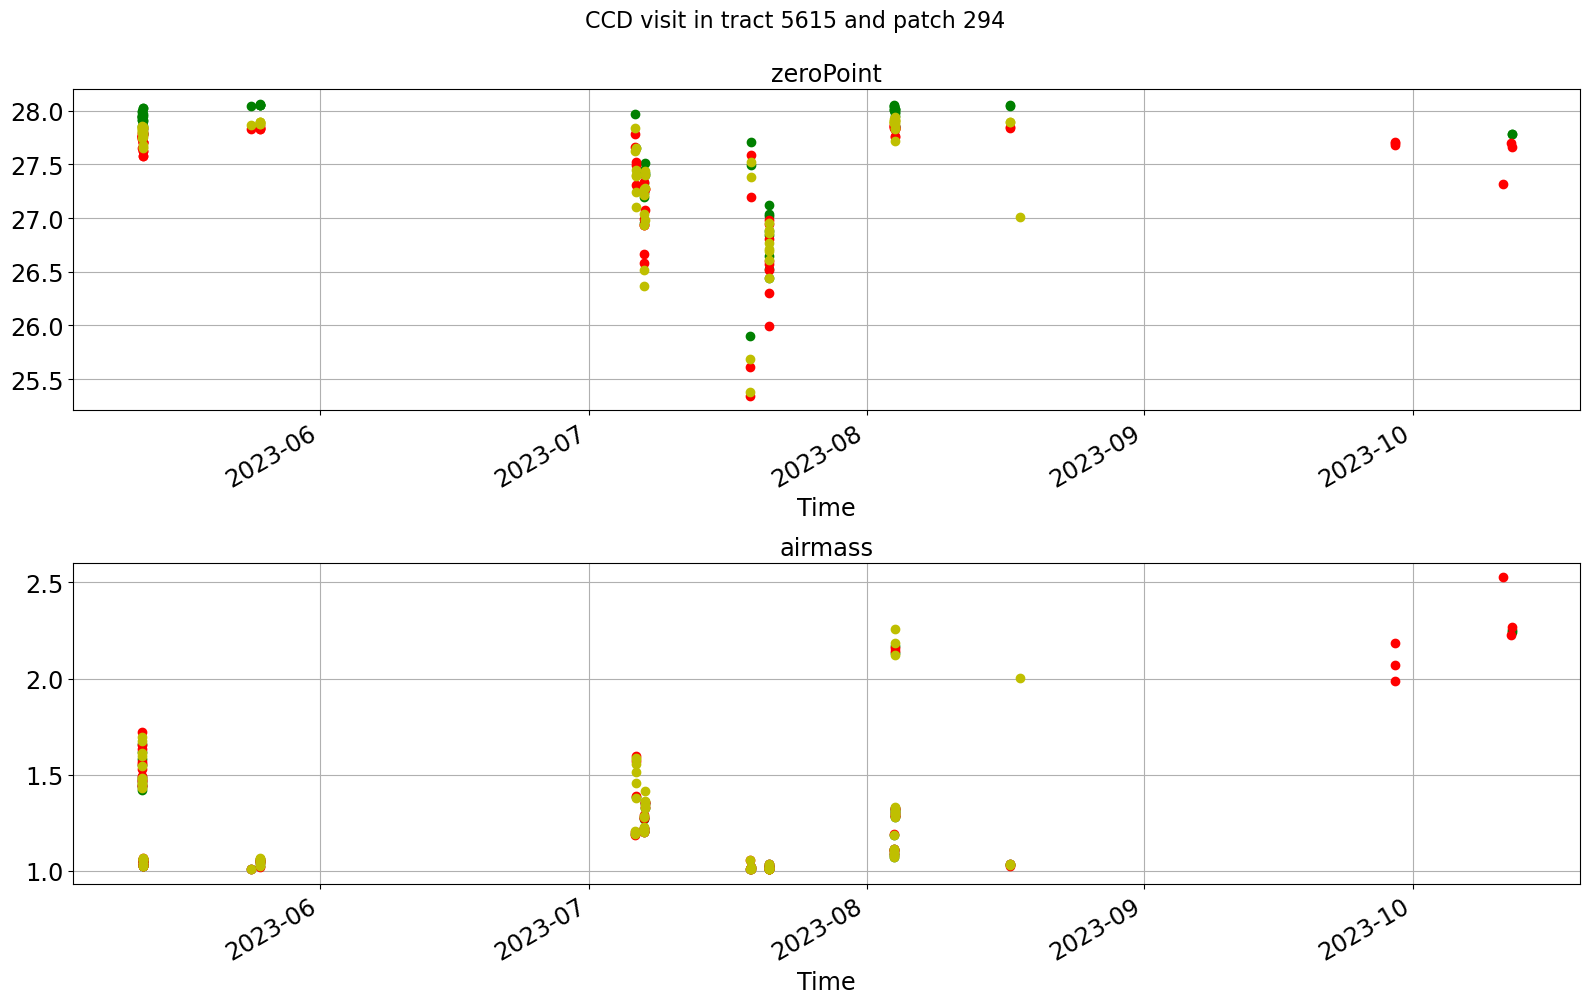

In [40]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")


df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Plot number of visit per day

### Plot number of visit per day for patch 294

/tmp/ipykernel_16290/1248664026.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


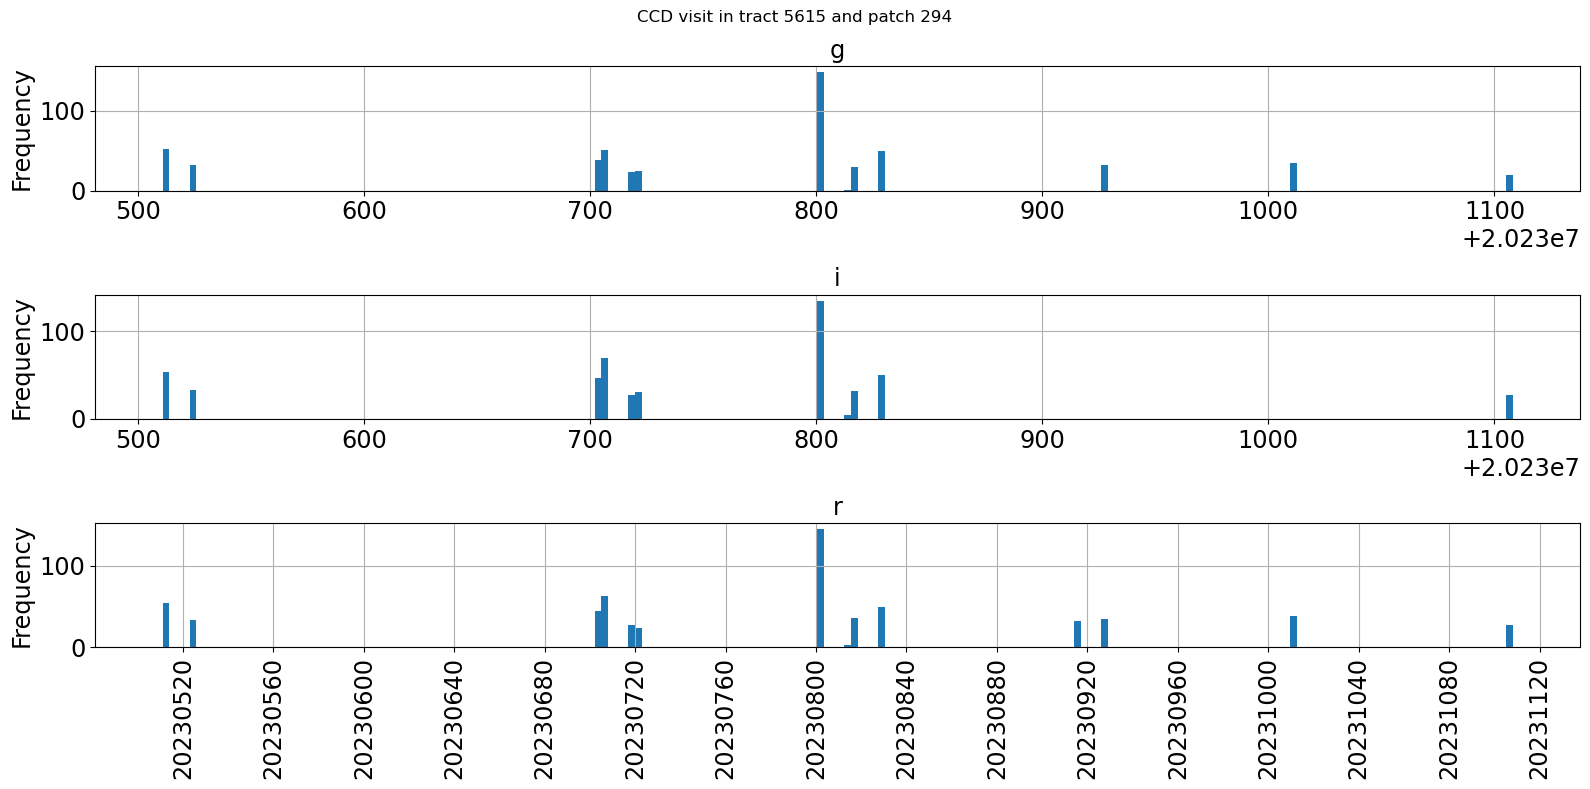

In [41]:

import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,8))
ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [43]:
ccd_visit_table_counts_byband = ccd_visit_table.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_byband.name = "countVisitperBandperNight" 
ccd_visit_table_counts_byband

nightObs  band
20230511  g        52
          i        54
          r        54
20230523  g        13
          i        13
          r        14
20230524  g        19
          i        20
          r        19
20230704  g        17
          i        18
          r        18
20230705  g        21
          i        29
          r        26
20230706  g        51
          i        69
          r        63
20230718  g        23
          i        27
          r        27
20230720  g        24
          i        31
          r        24
20230801  g        14
          i        12
          r        13
20230802  g        22
          i        15
          r        18
20230803  g       112
          i       108
          r       114
20230815  g         1
          i         4
          r         3
20230816  g         4
          i         4
          r         4
20230817  g        26
          i        28
          r        32
20230829  g        50
          i        50
          r      

In [44]:
ccd_visit_table_counts = ccd_visit_table.groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts.name = "countVisitperNight" 
ccd_visit_table_counts

nightObs
20230511    160
20230523     40
20230524     58
20230704     53
20230705     76
20230706    183
20230718     77
20230720     79
20230801     39
20230802     55
20230803    334
20230815      8
20230816     12
20230817     86
20230829    150
20230914     32
20230927     10
20230928     57
20231010     69
20231011      4
20231107     26
20231108     47
Name: countVisitperNight, dtype: int64

## Loop on all nights

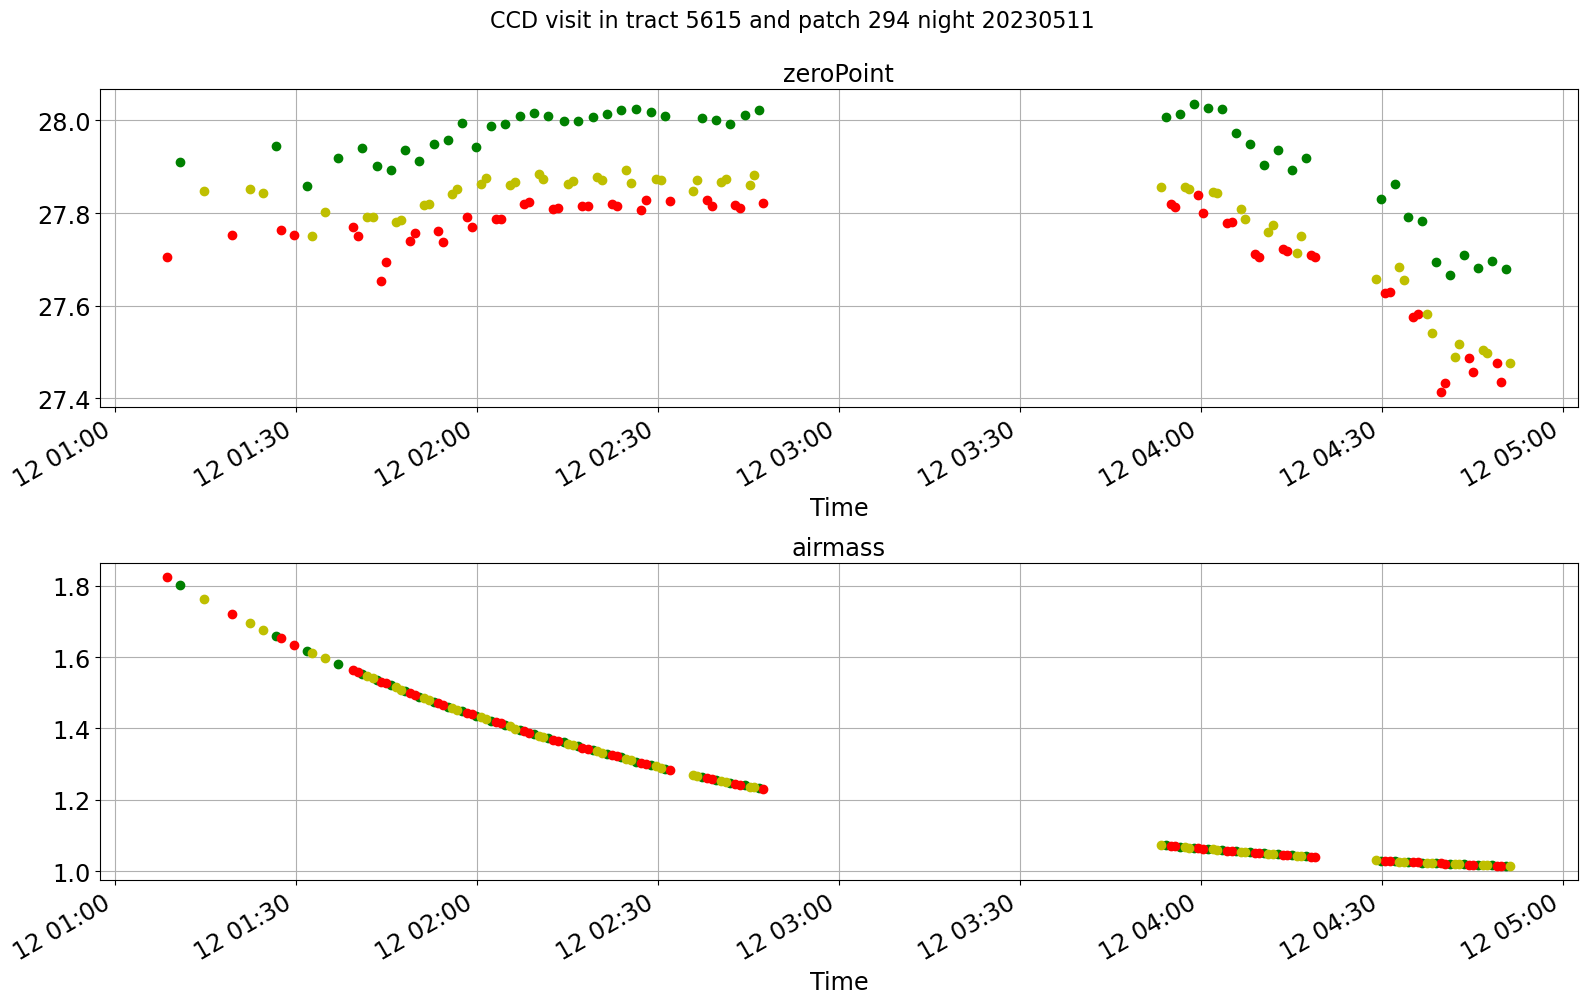

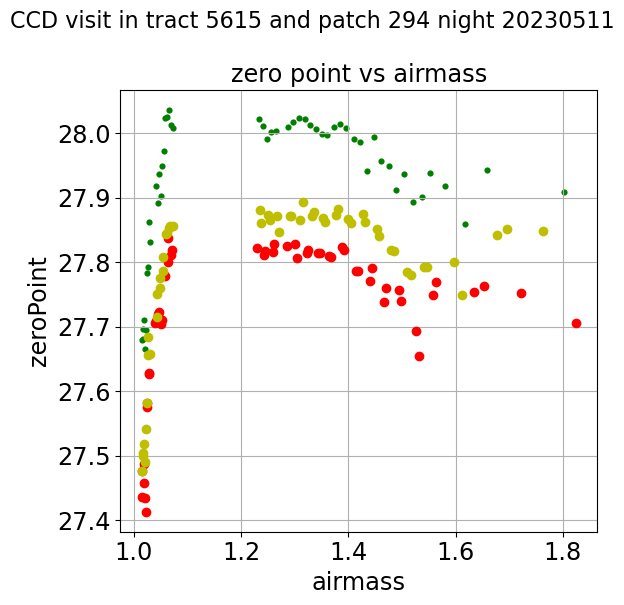

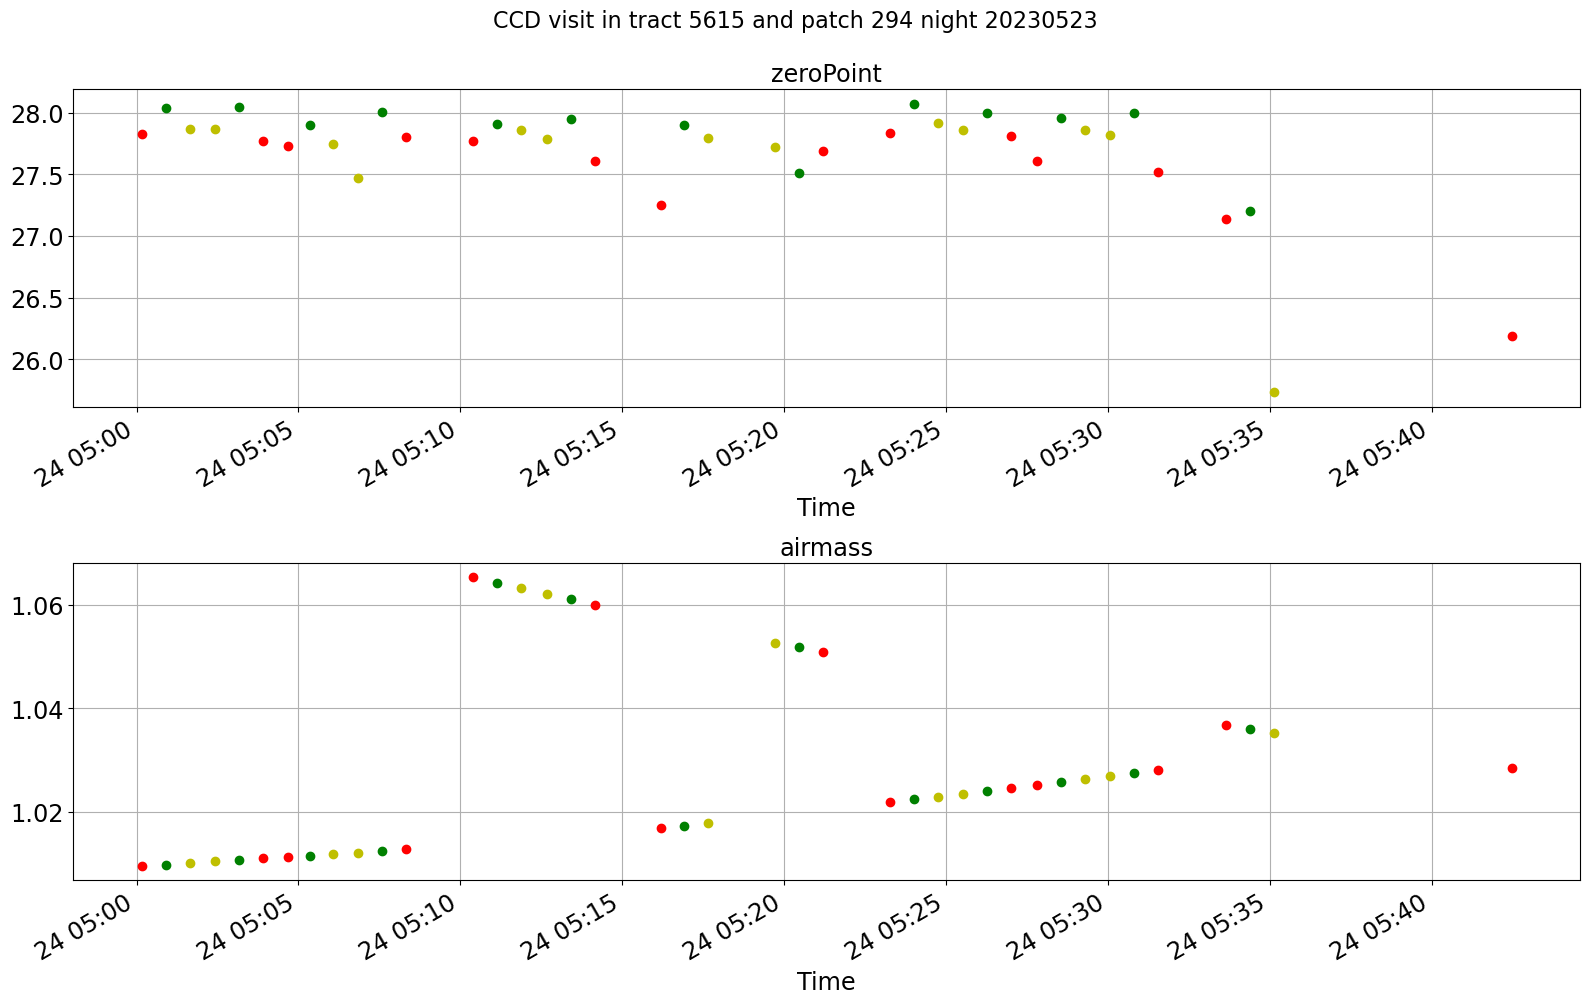

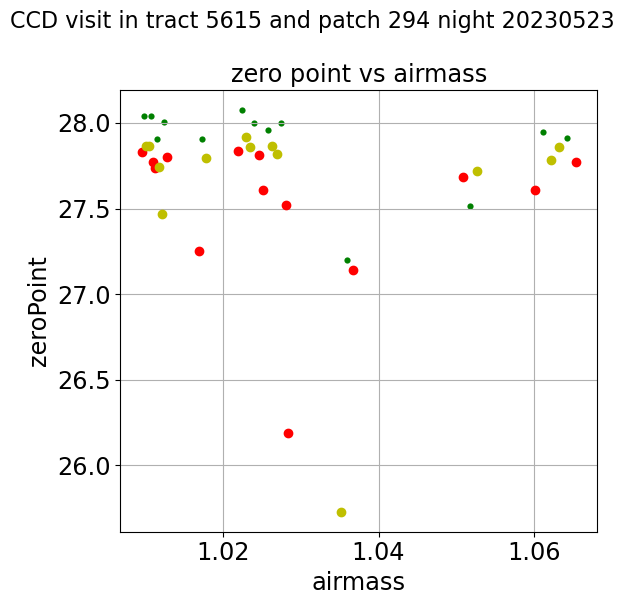

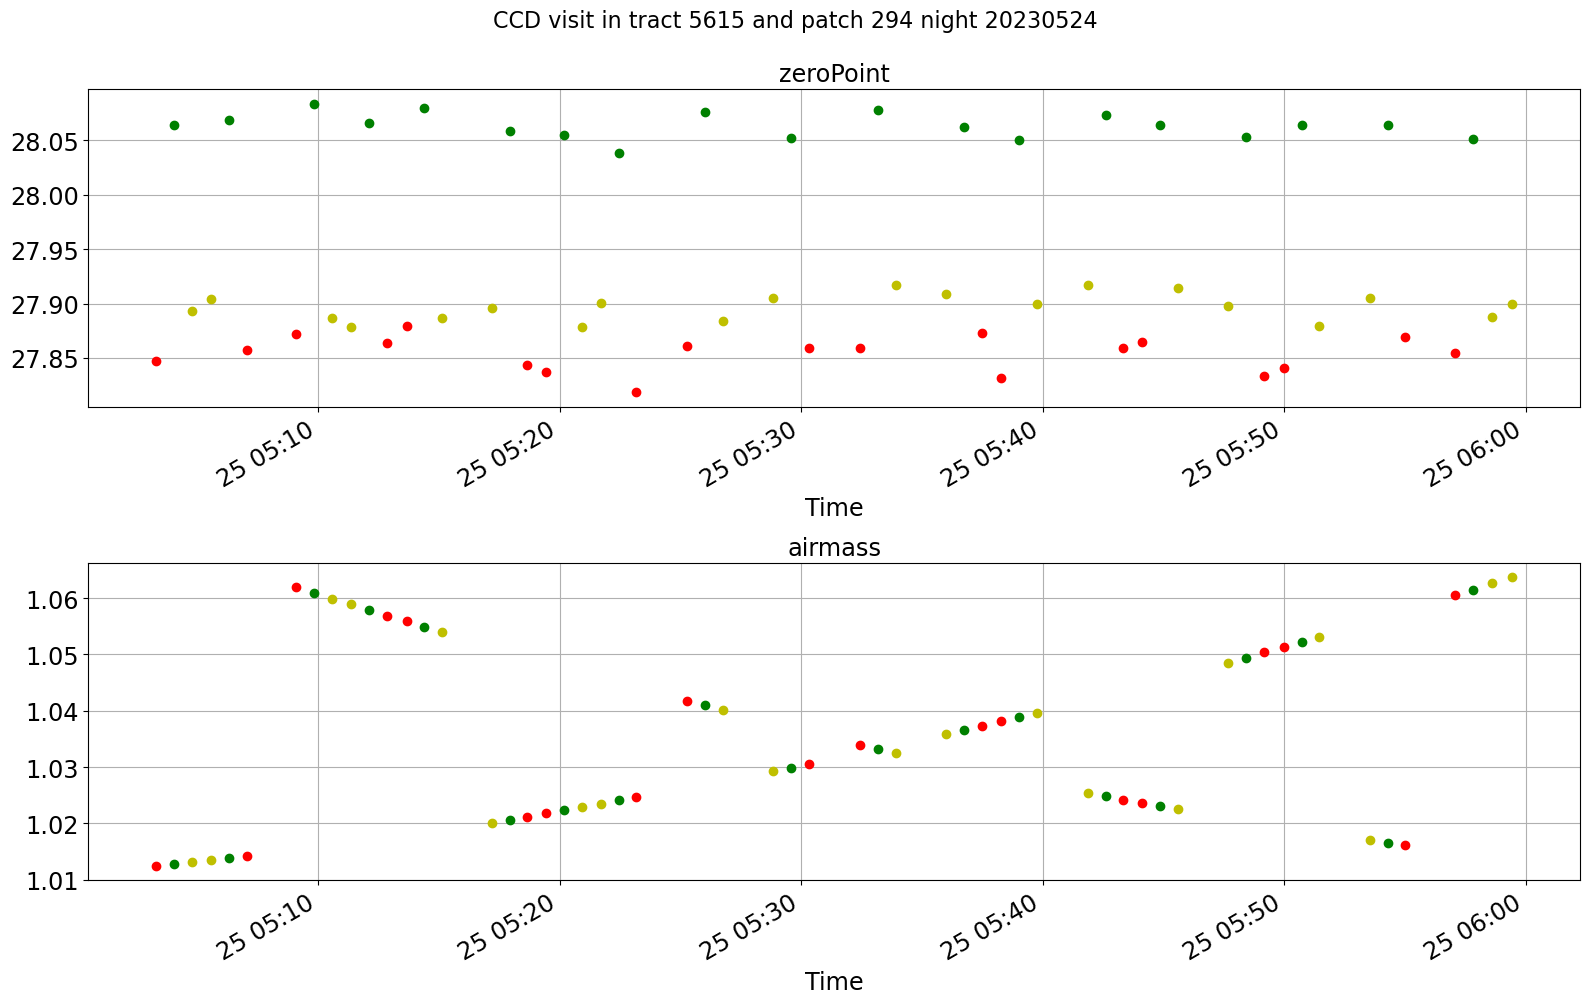

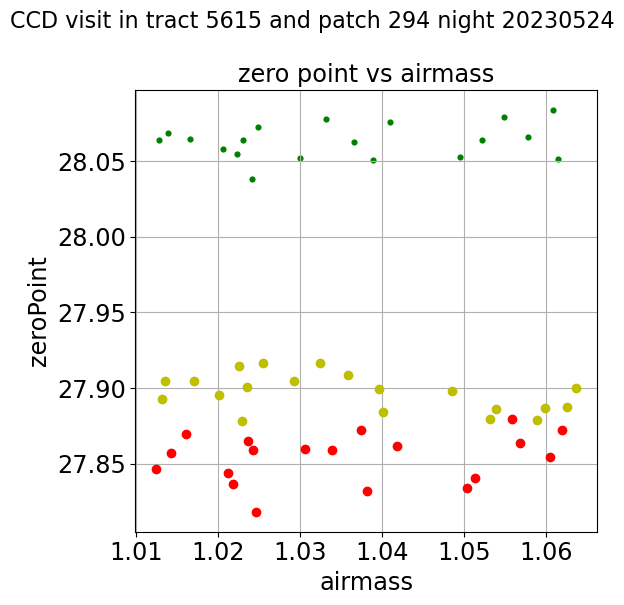

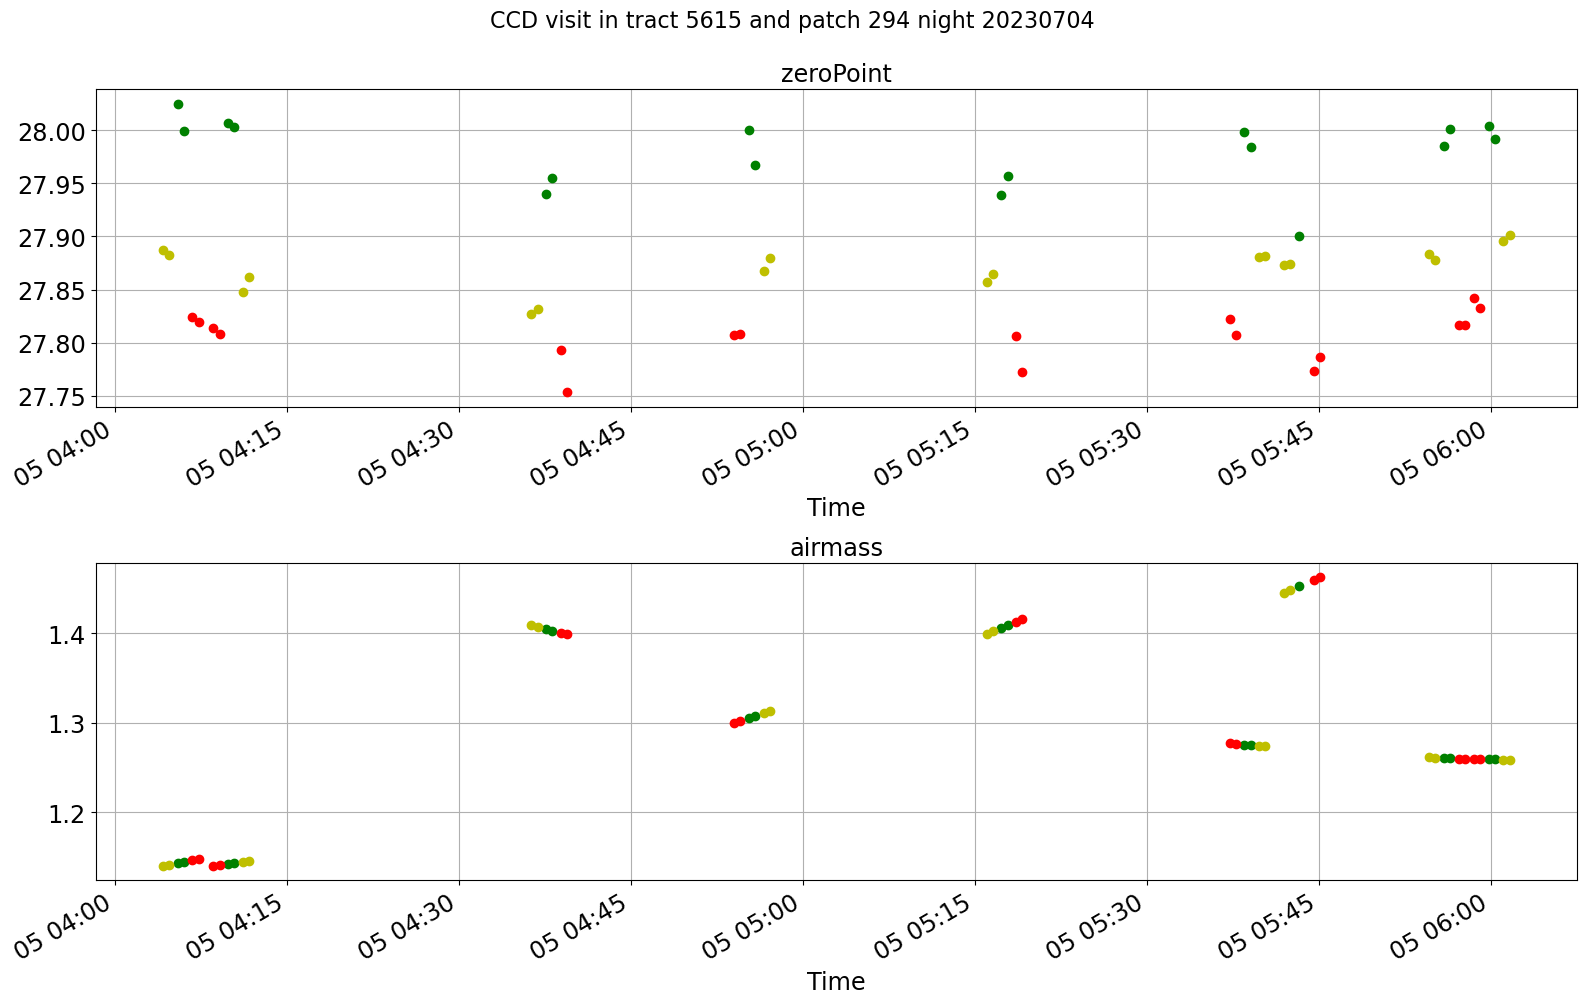

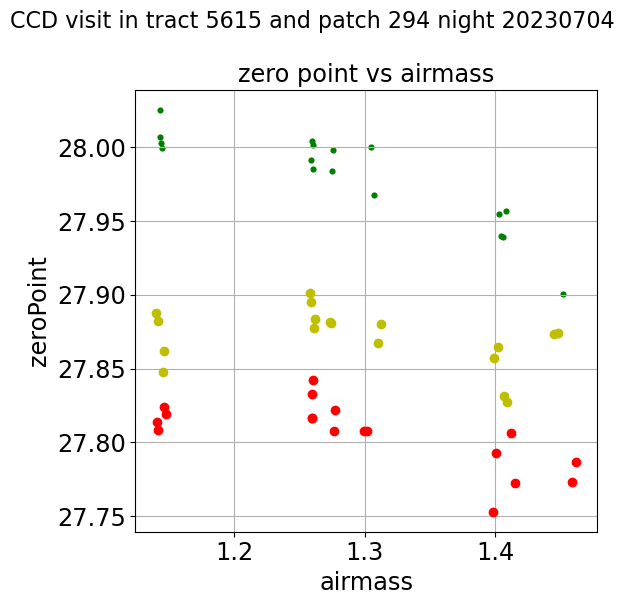

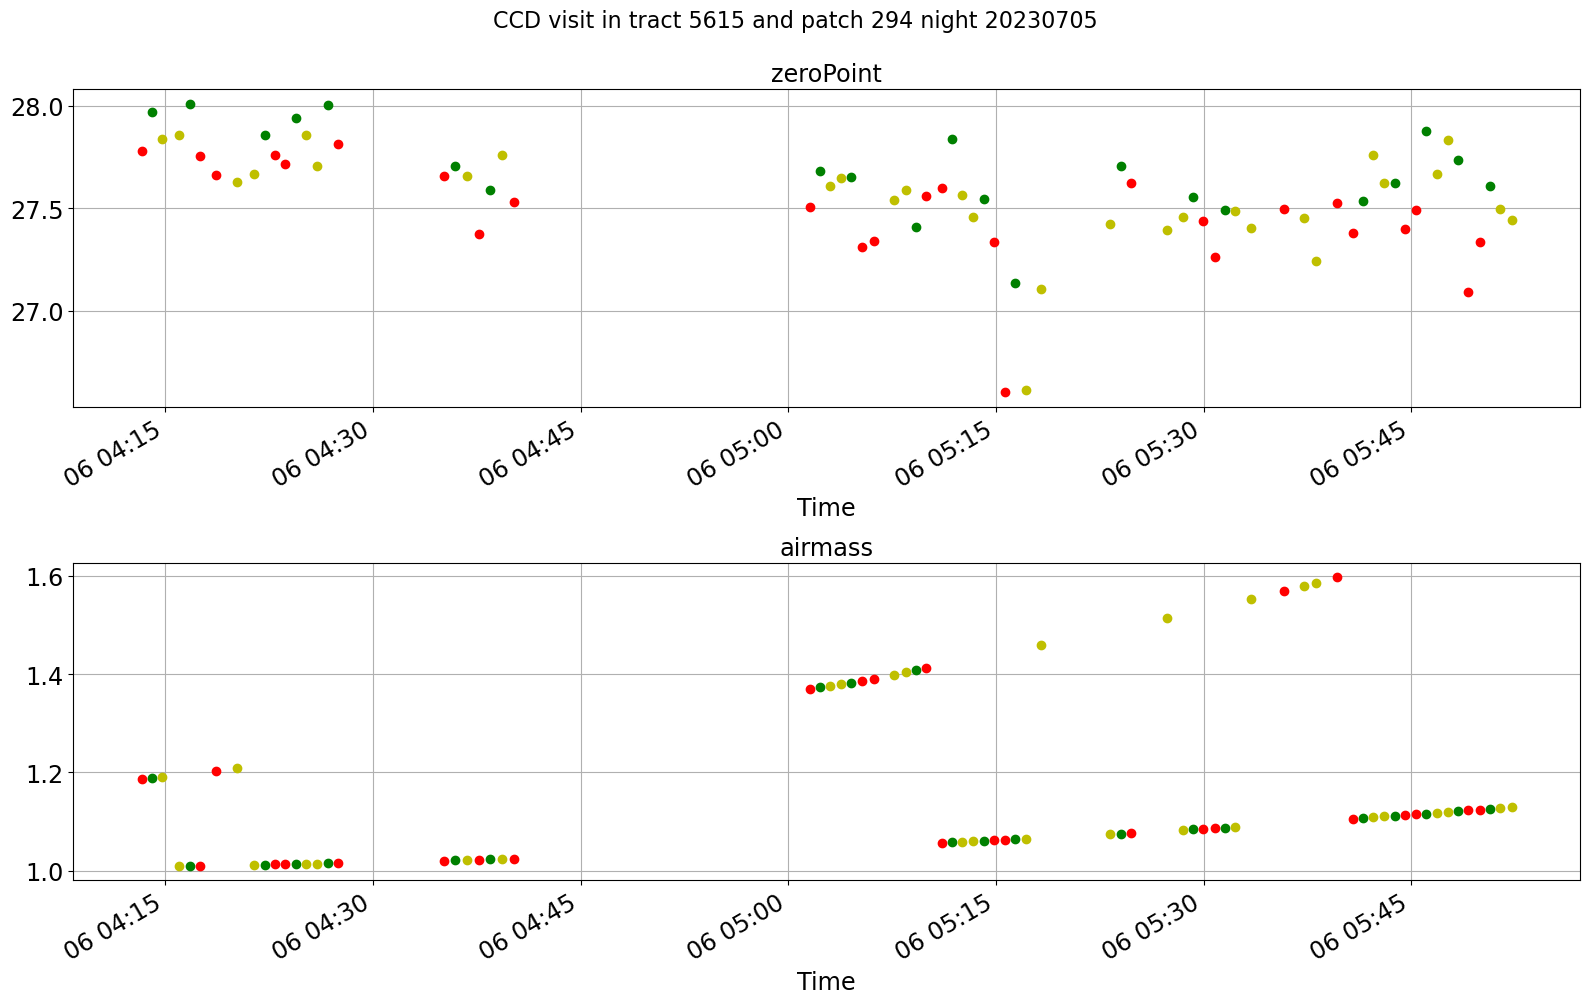

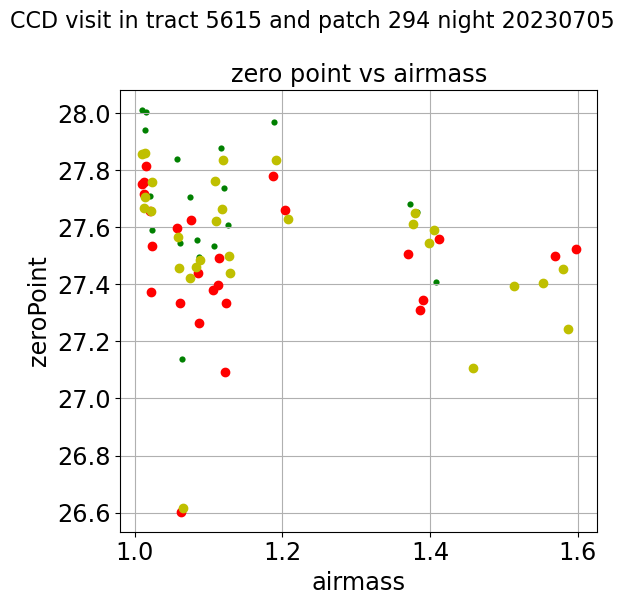

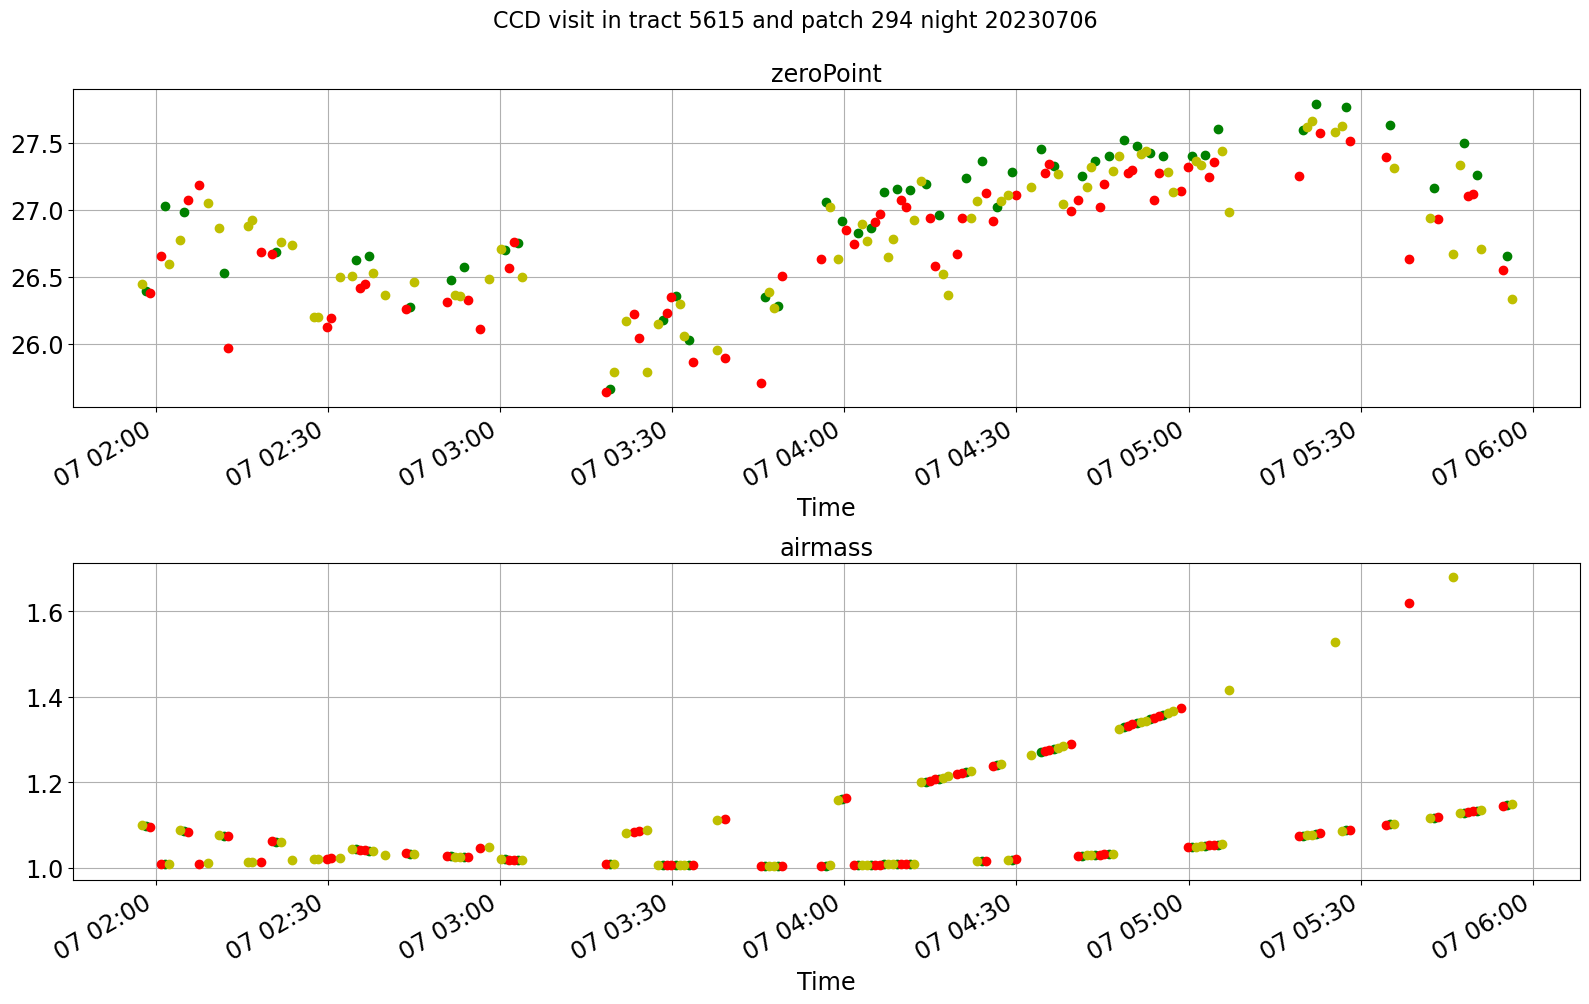

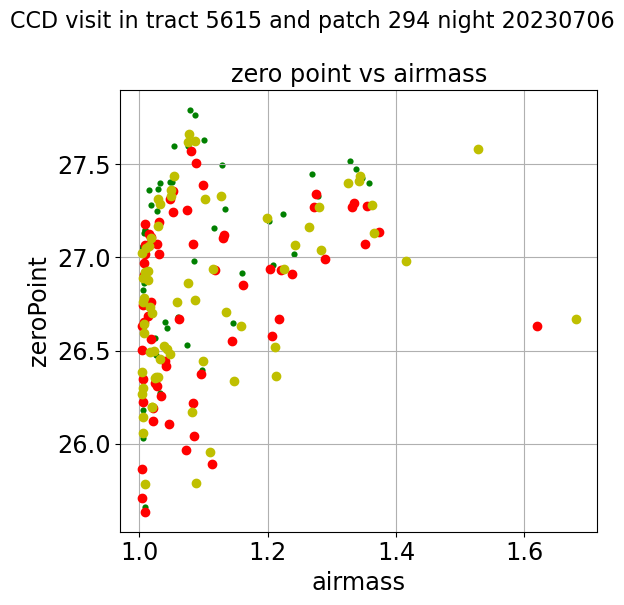

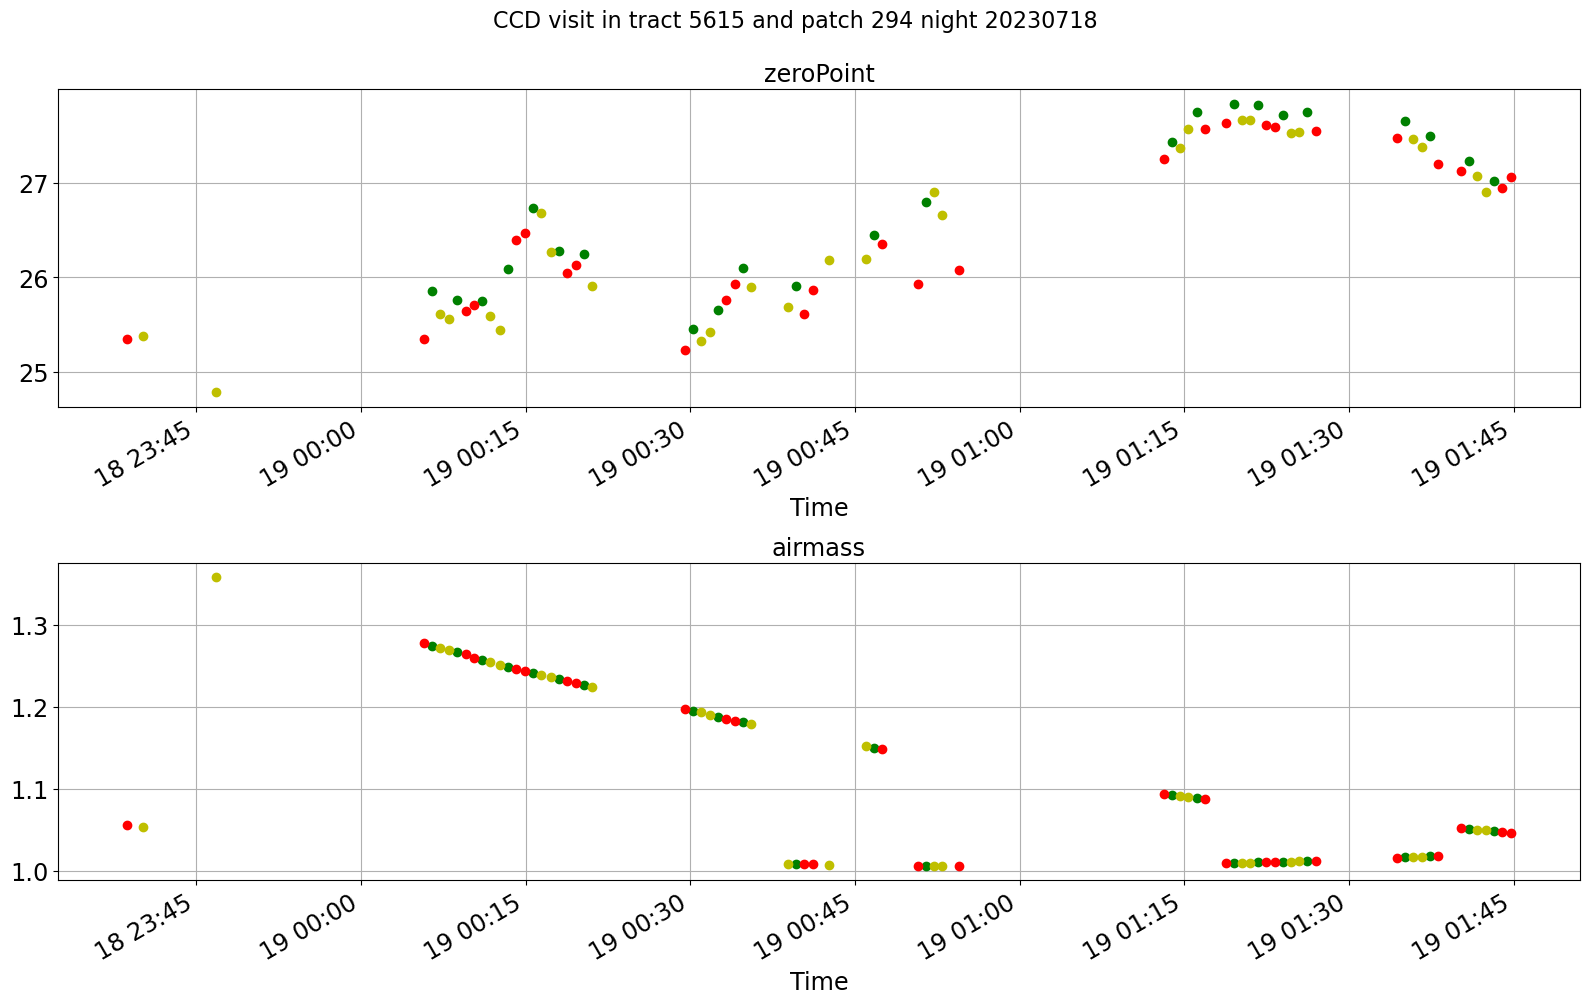

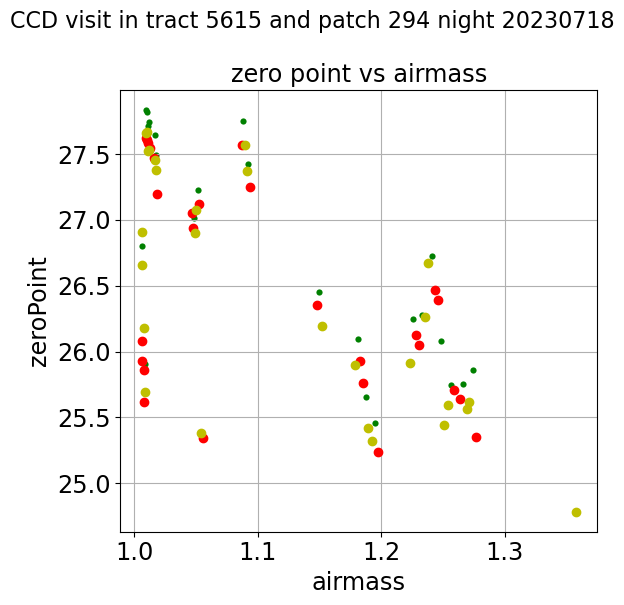

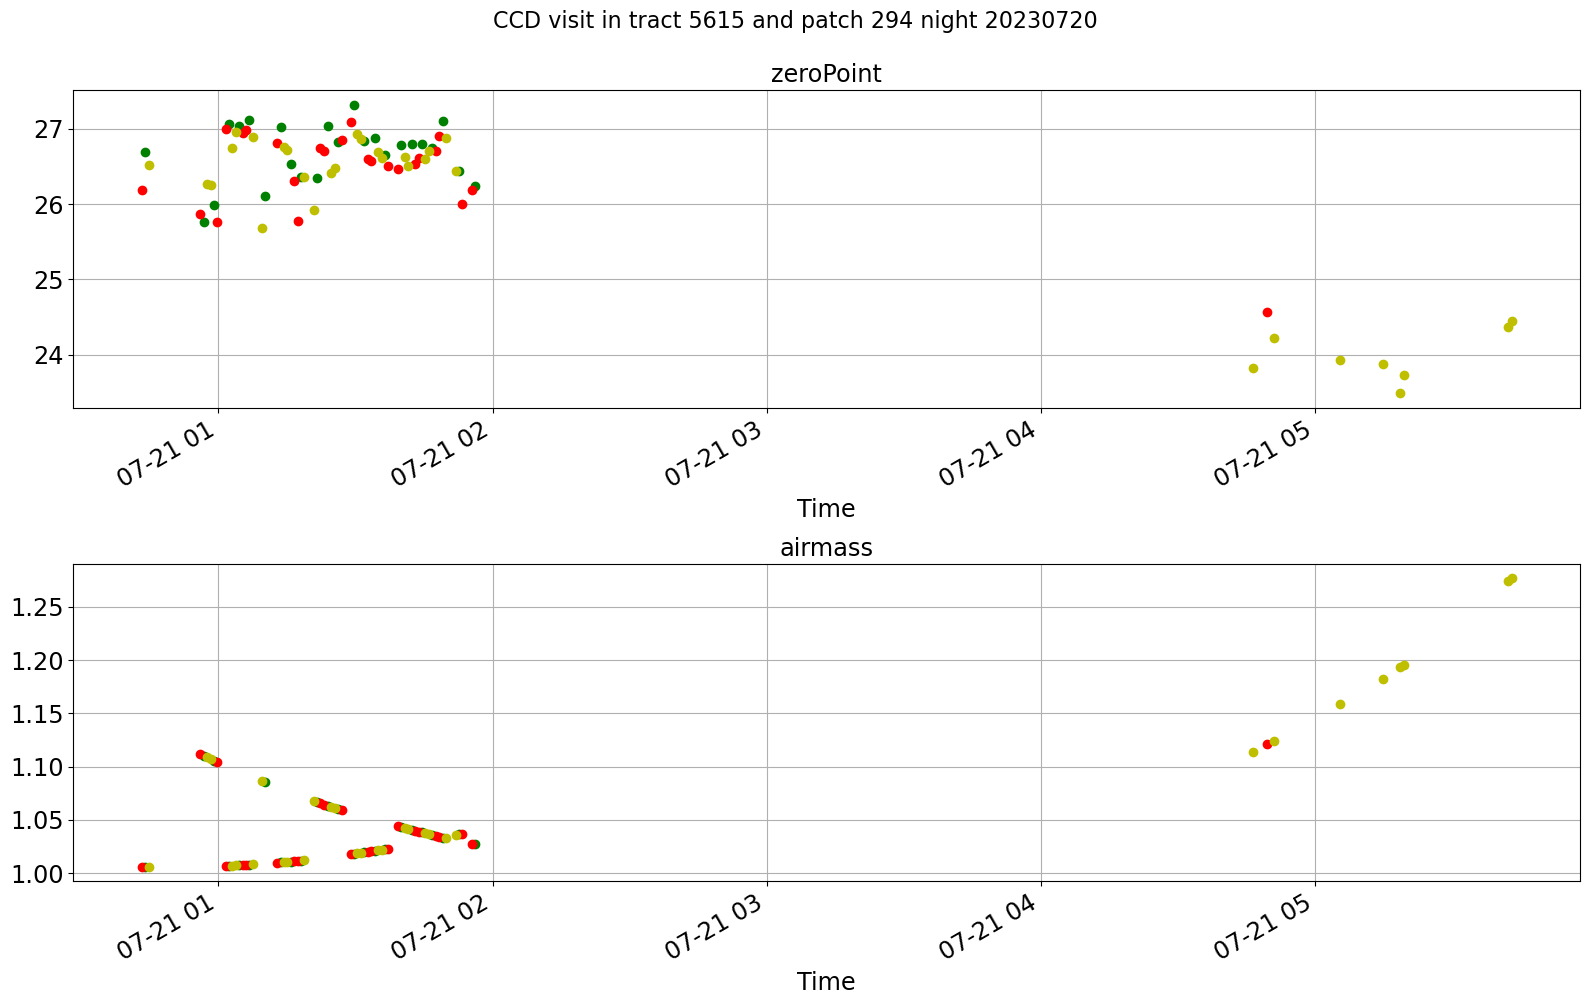

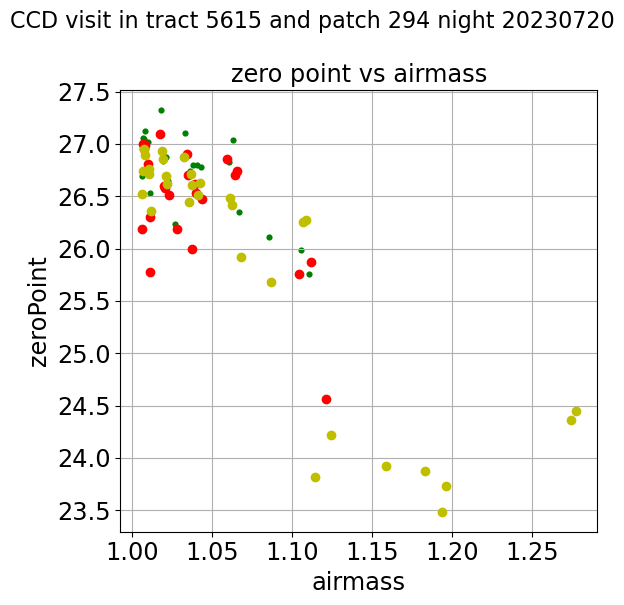

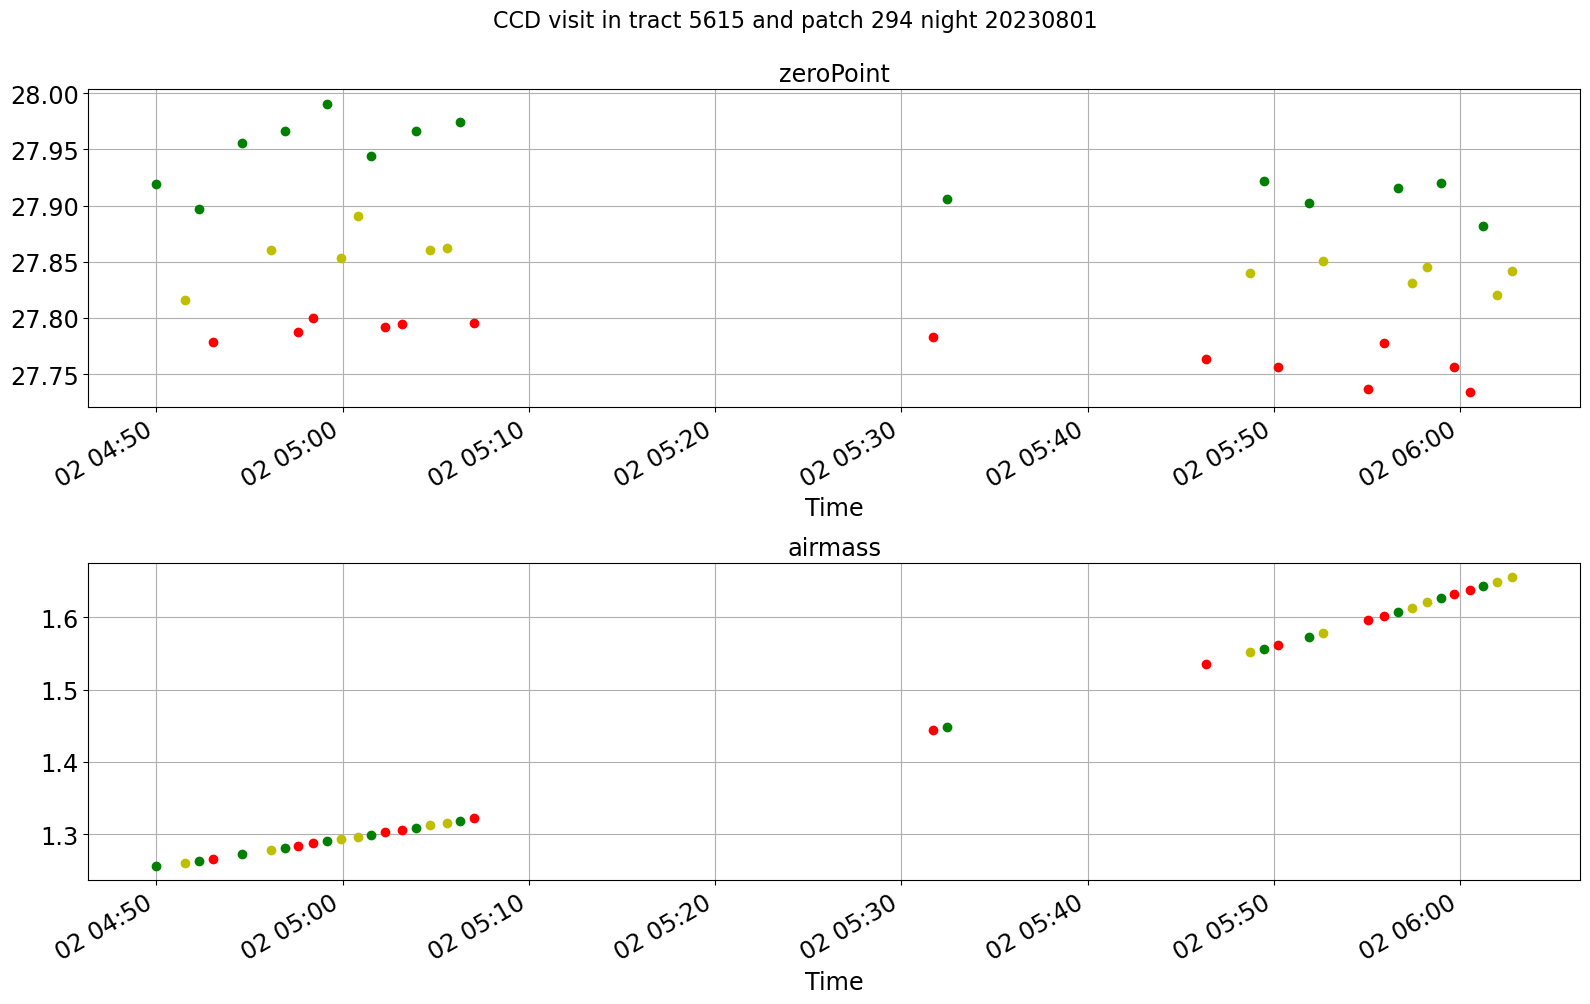

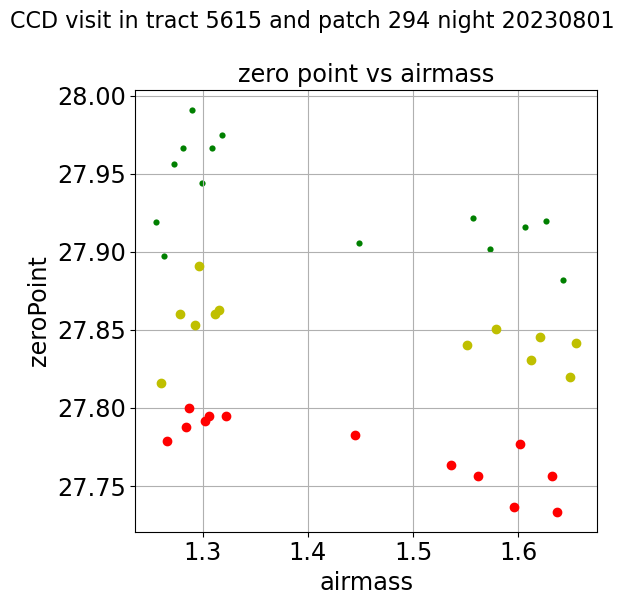

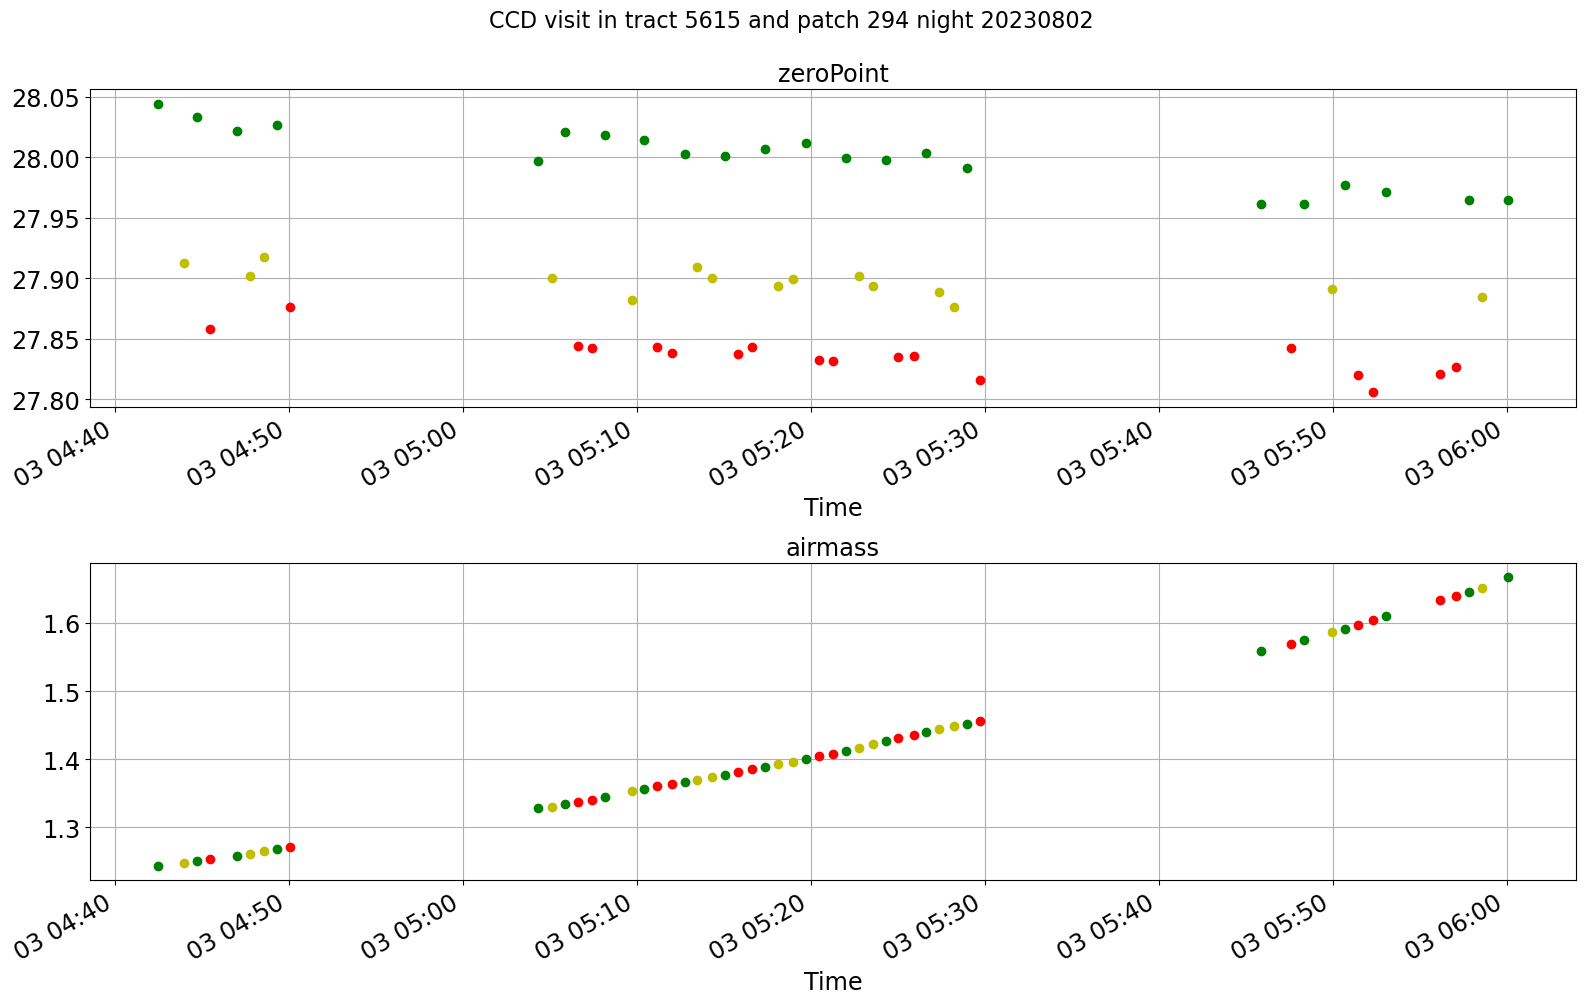

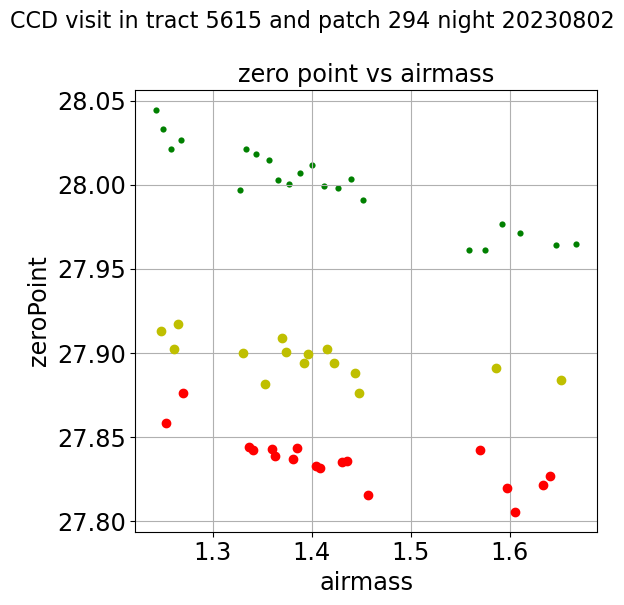

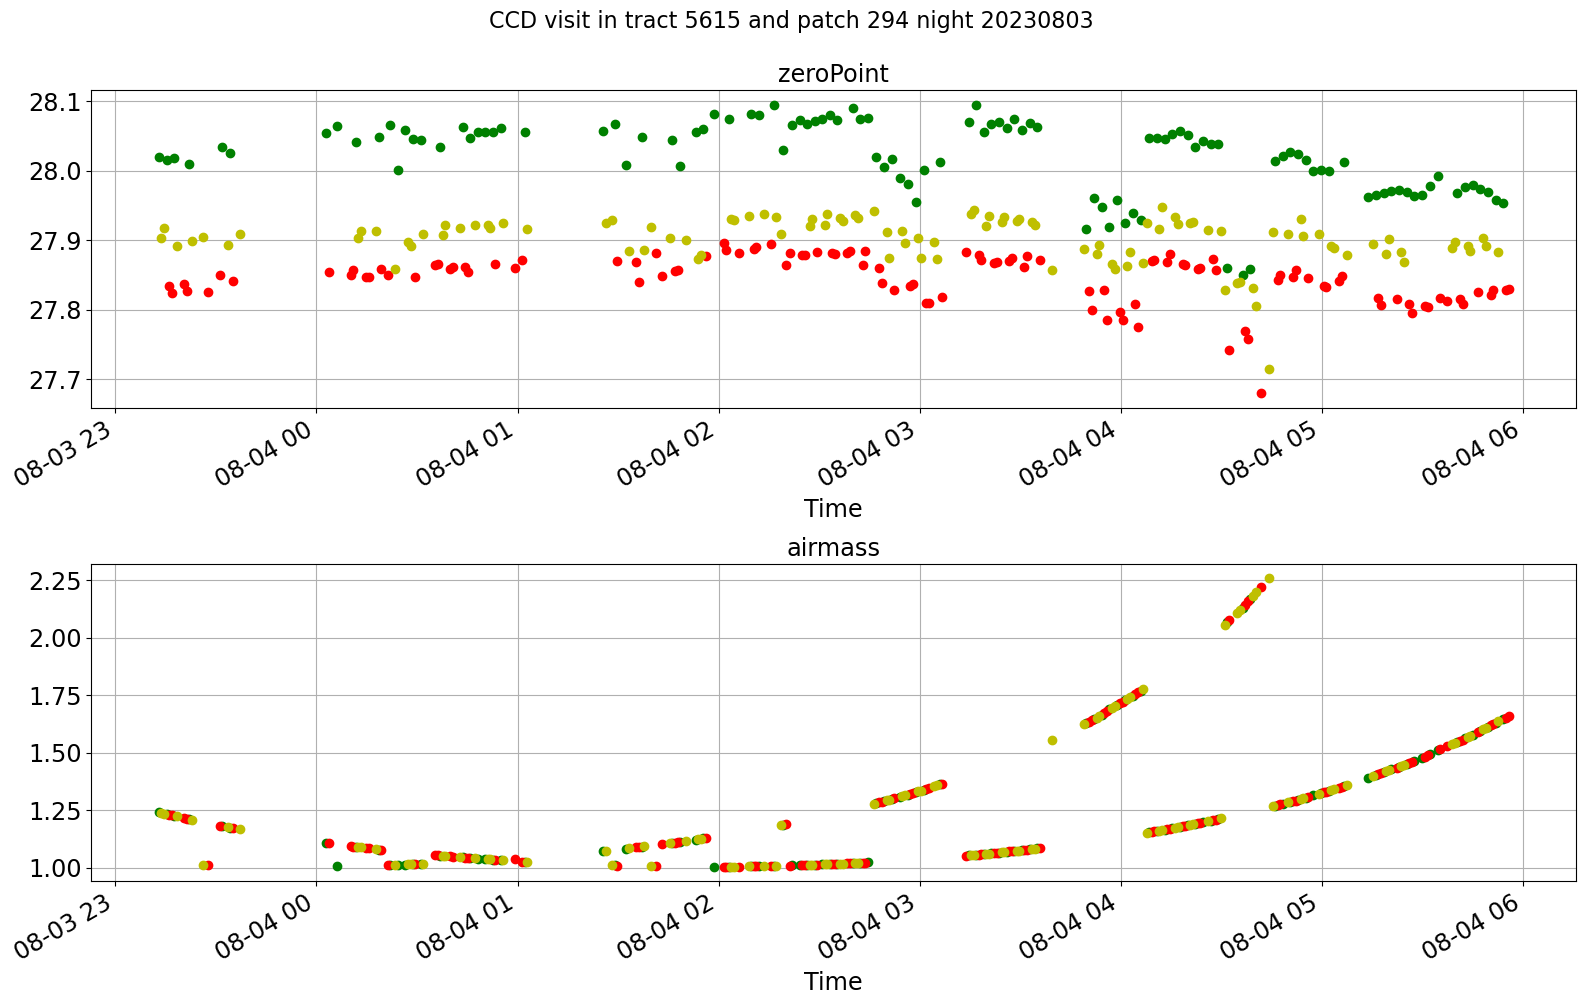

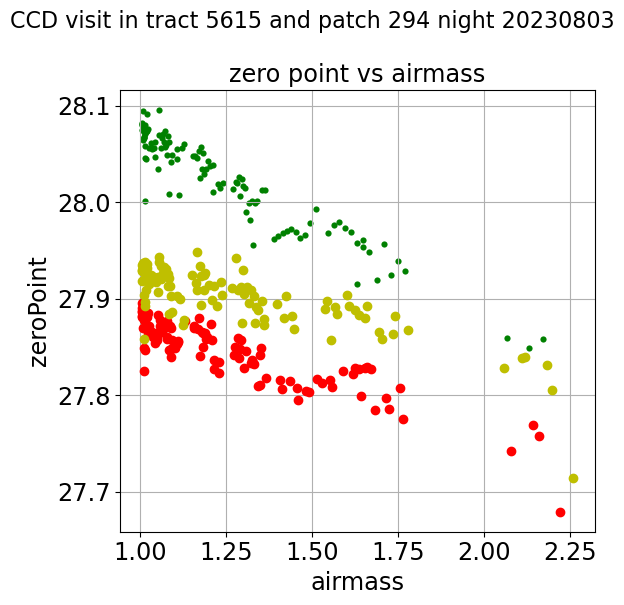

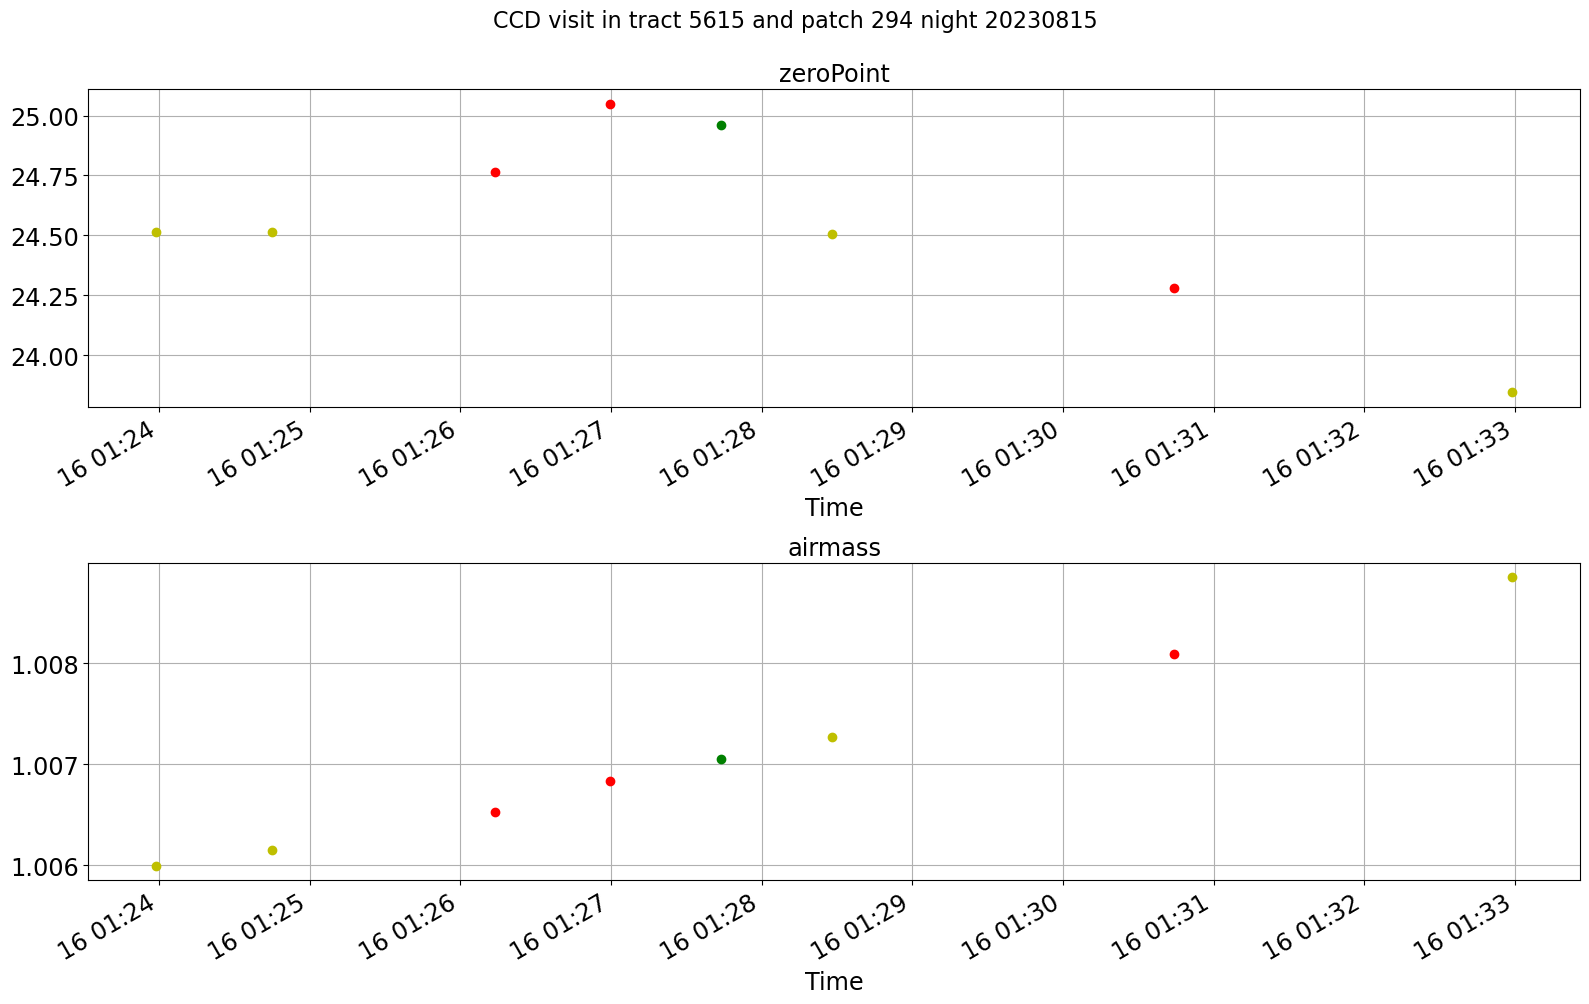

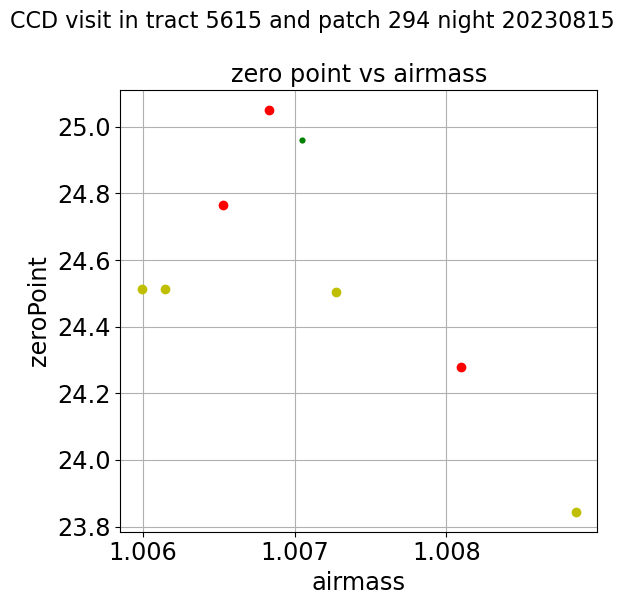

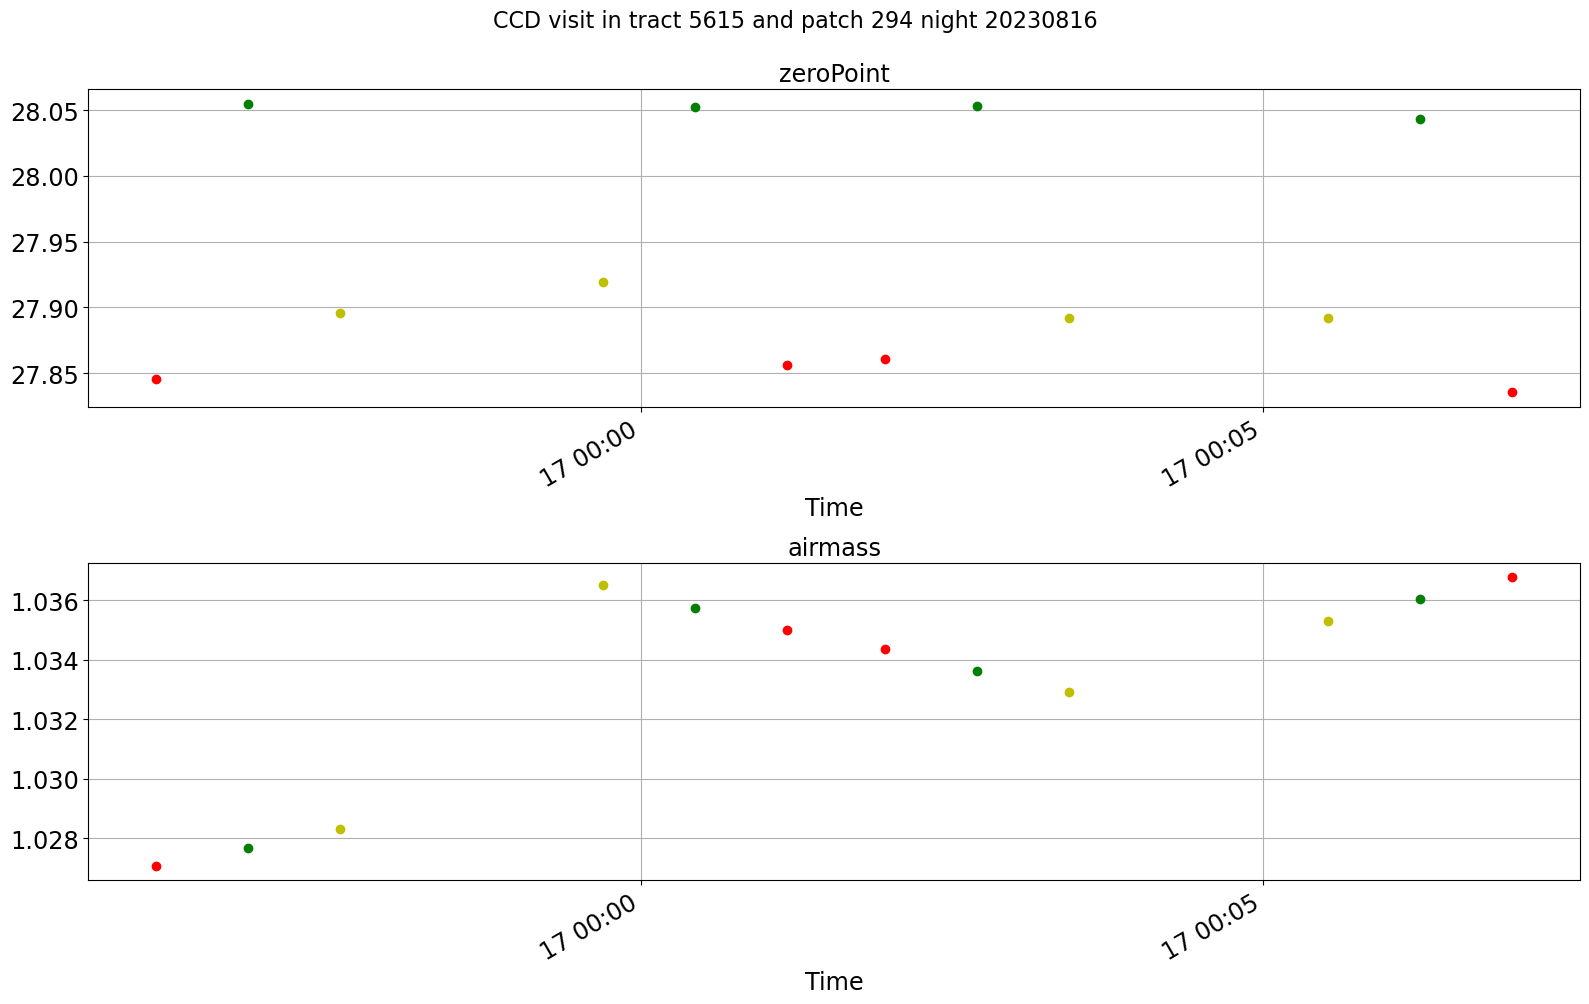

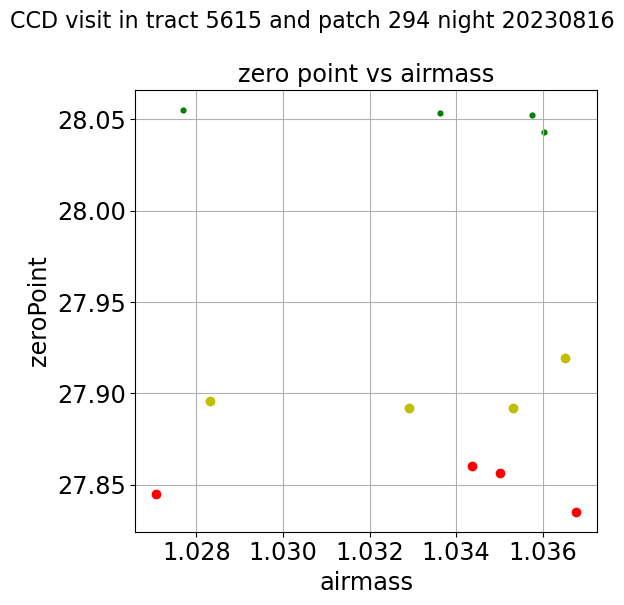

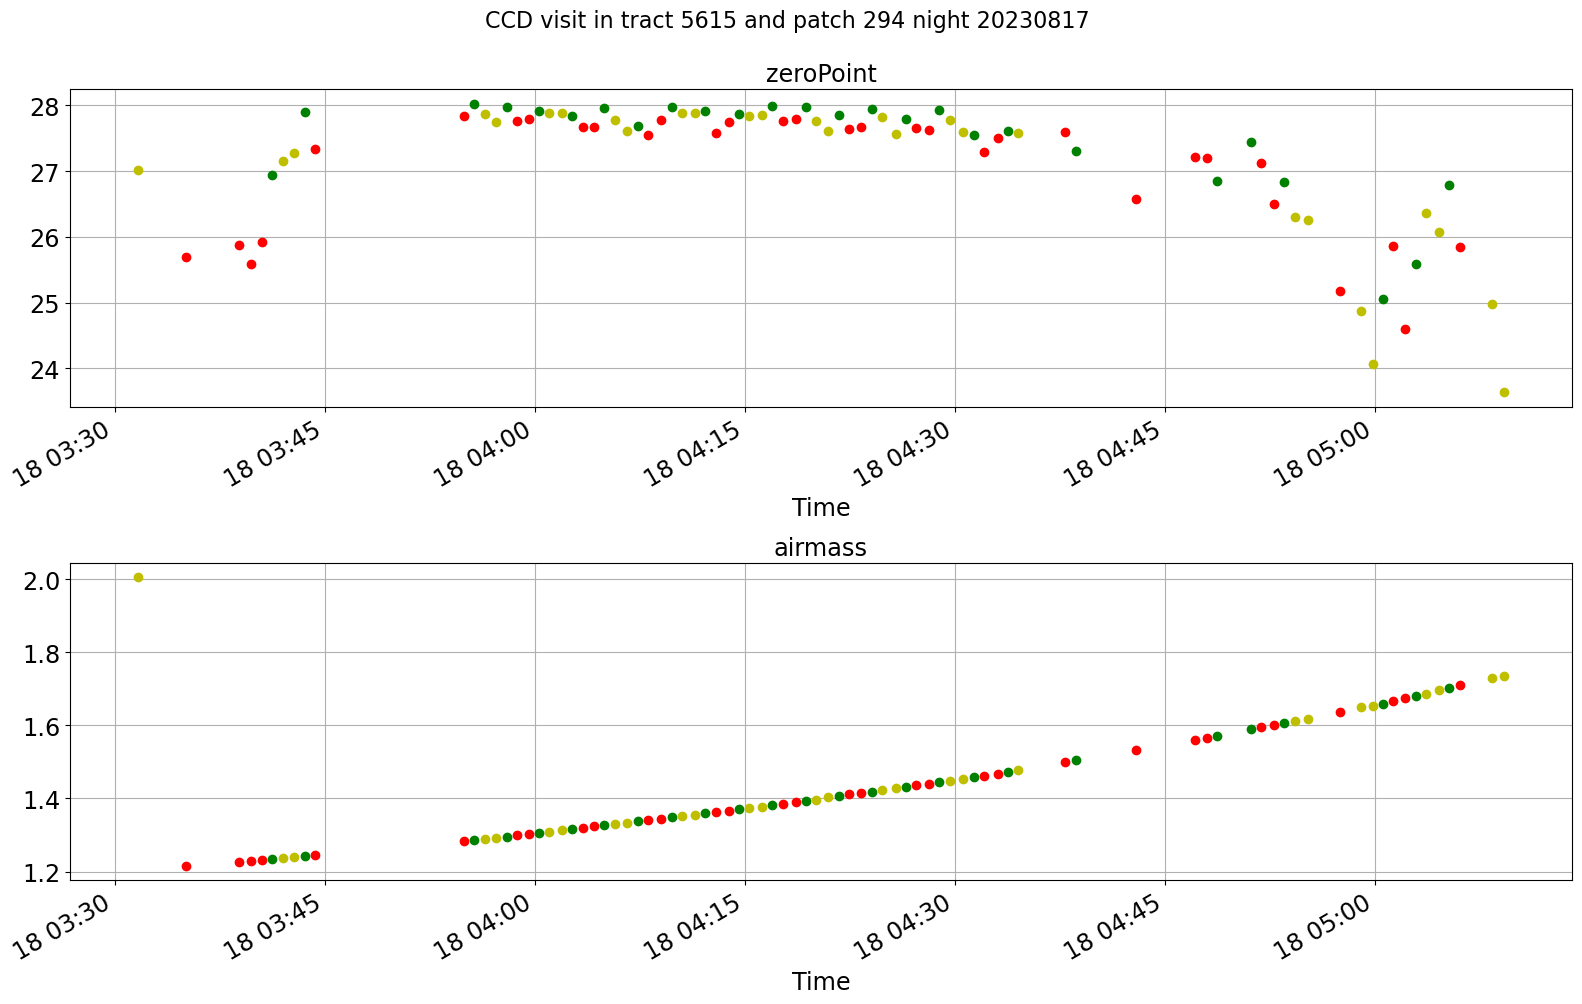

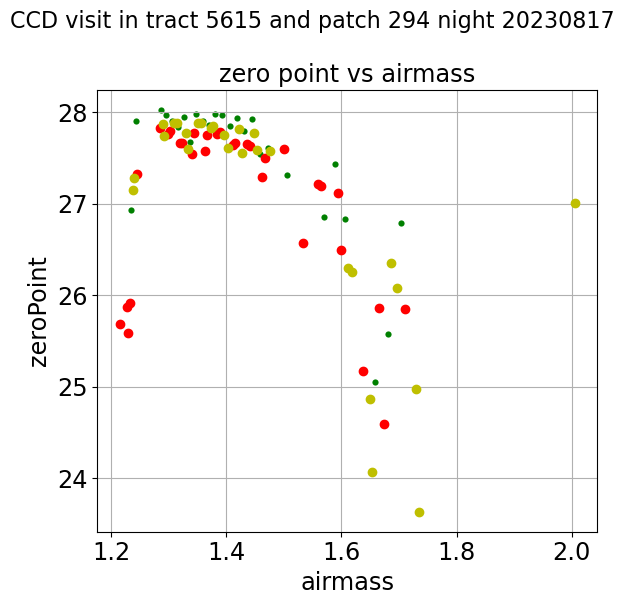

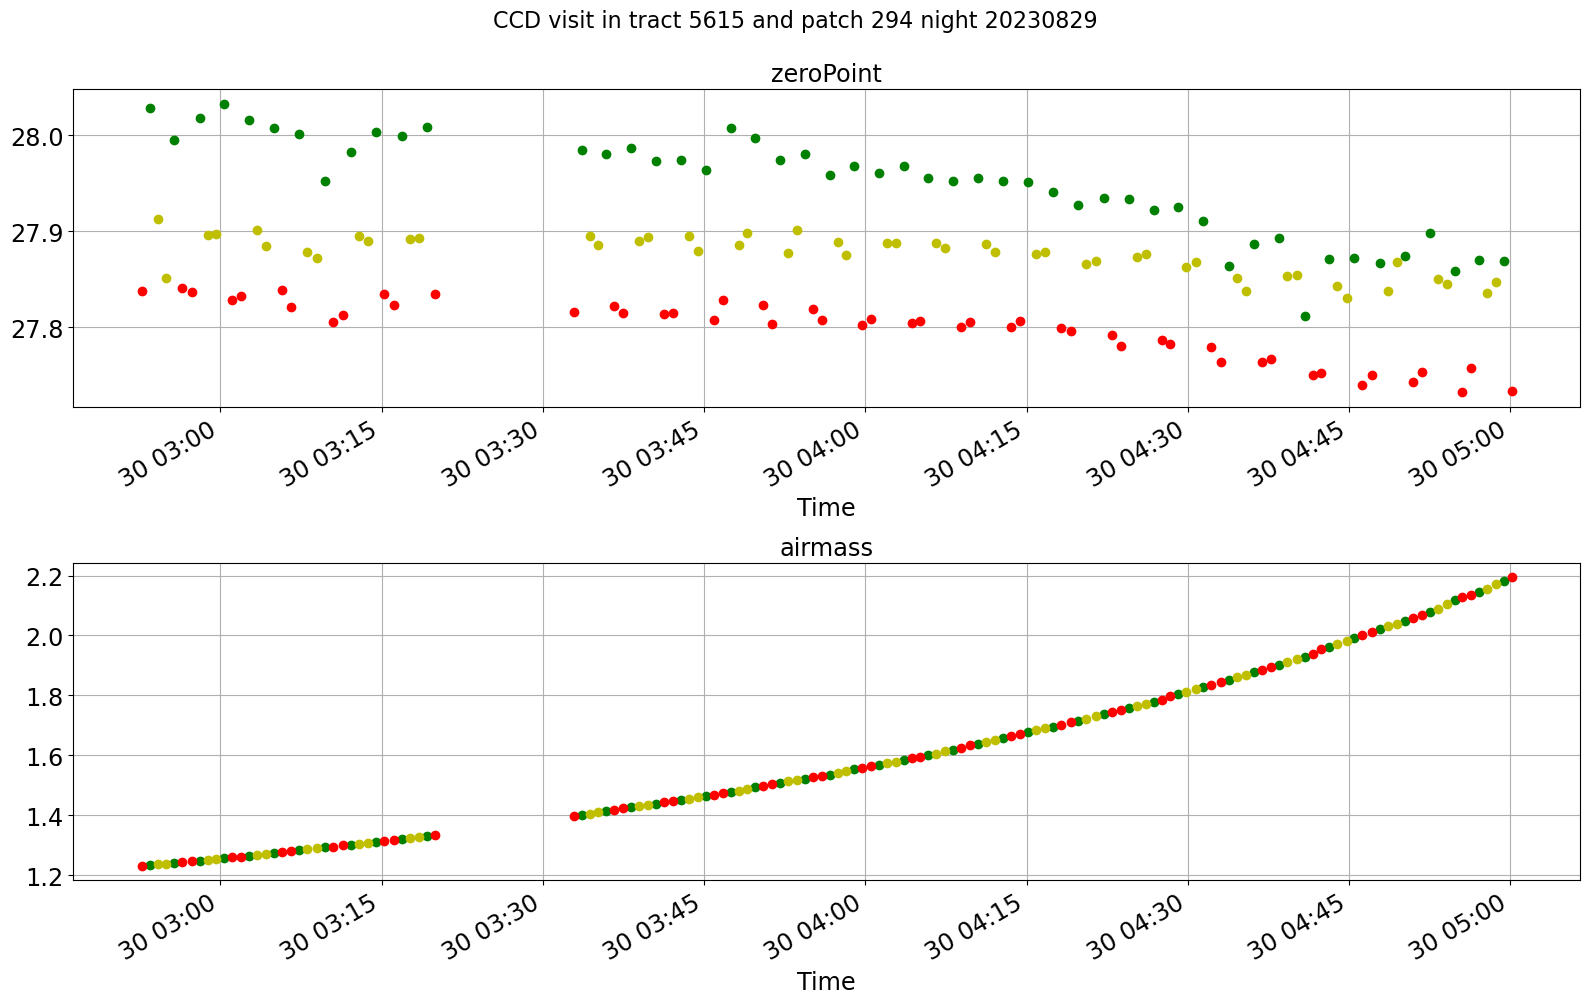

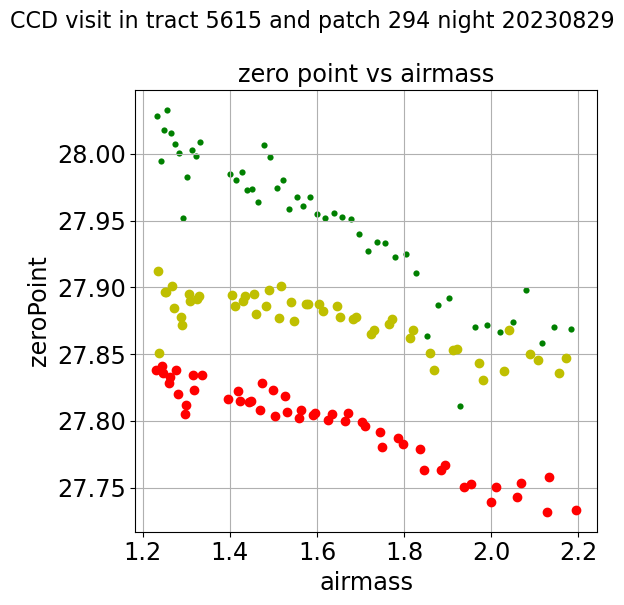

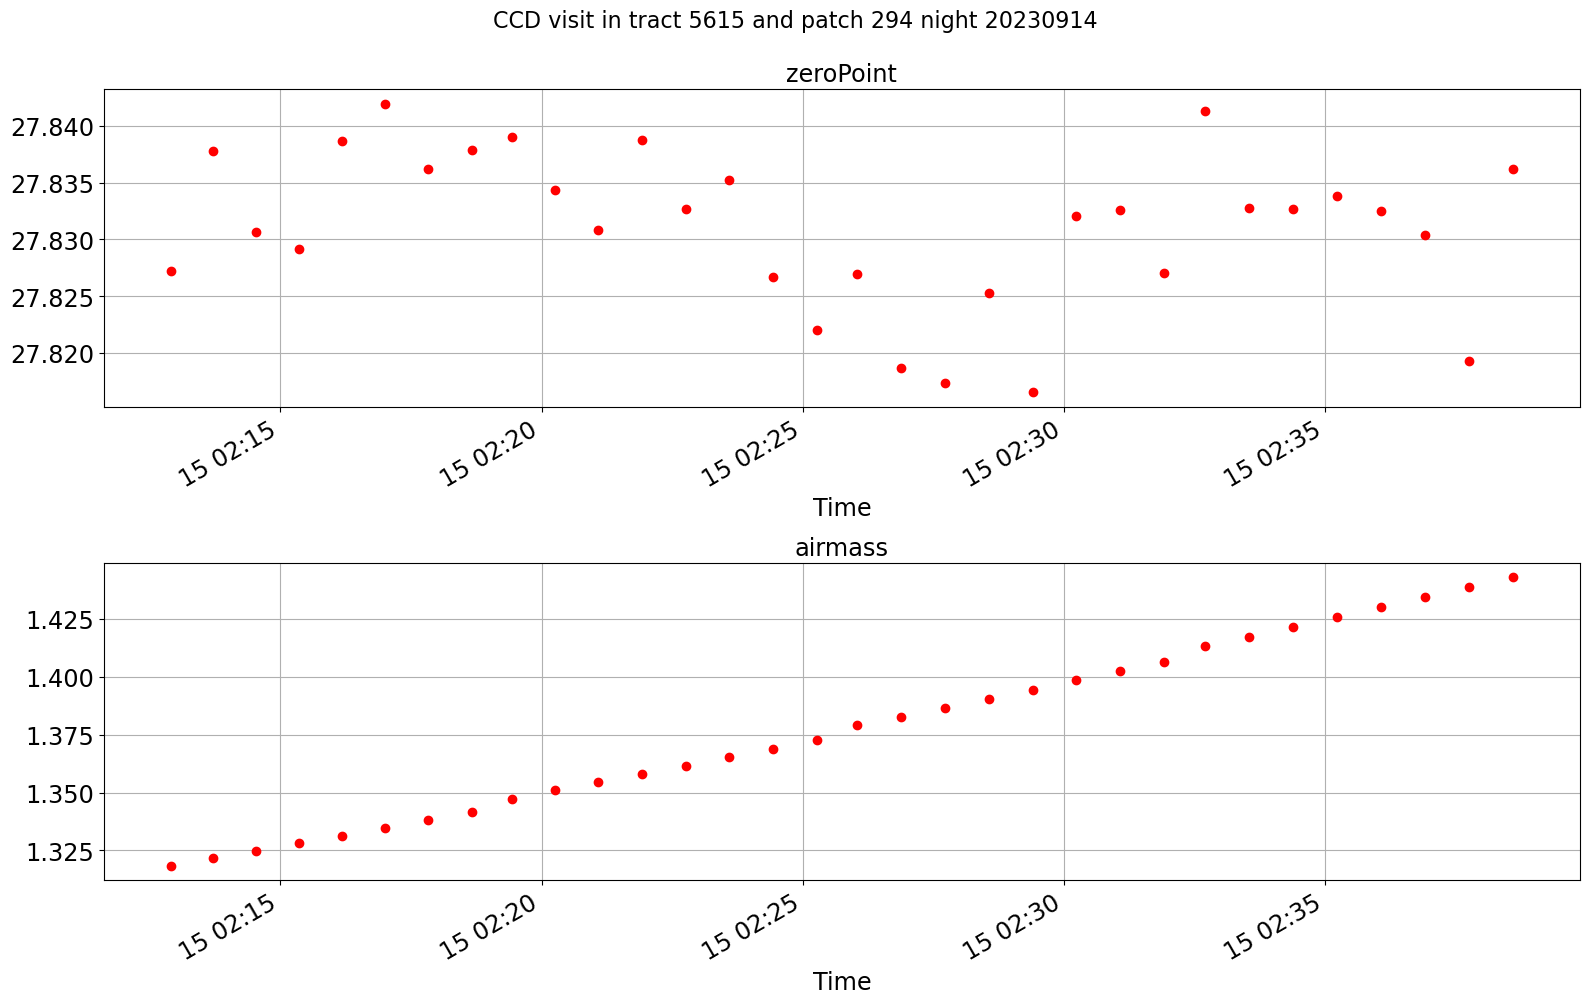

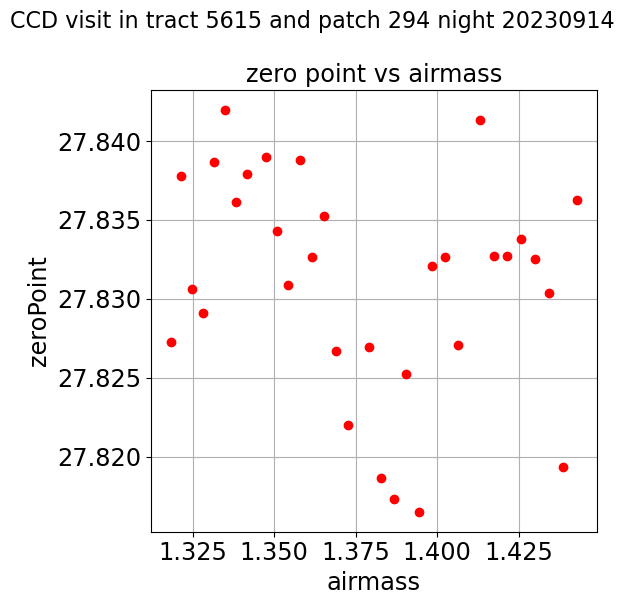

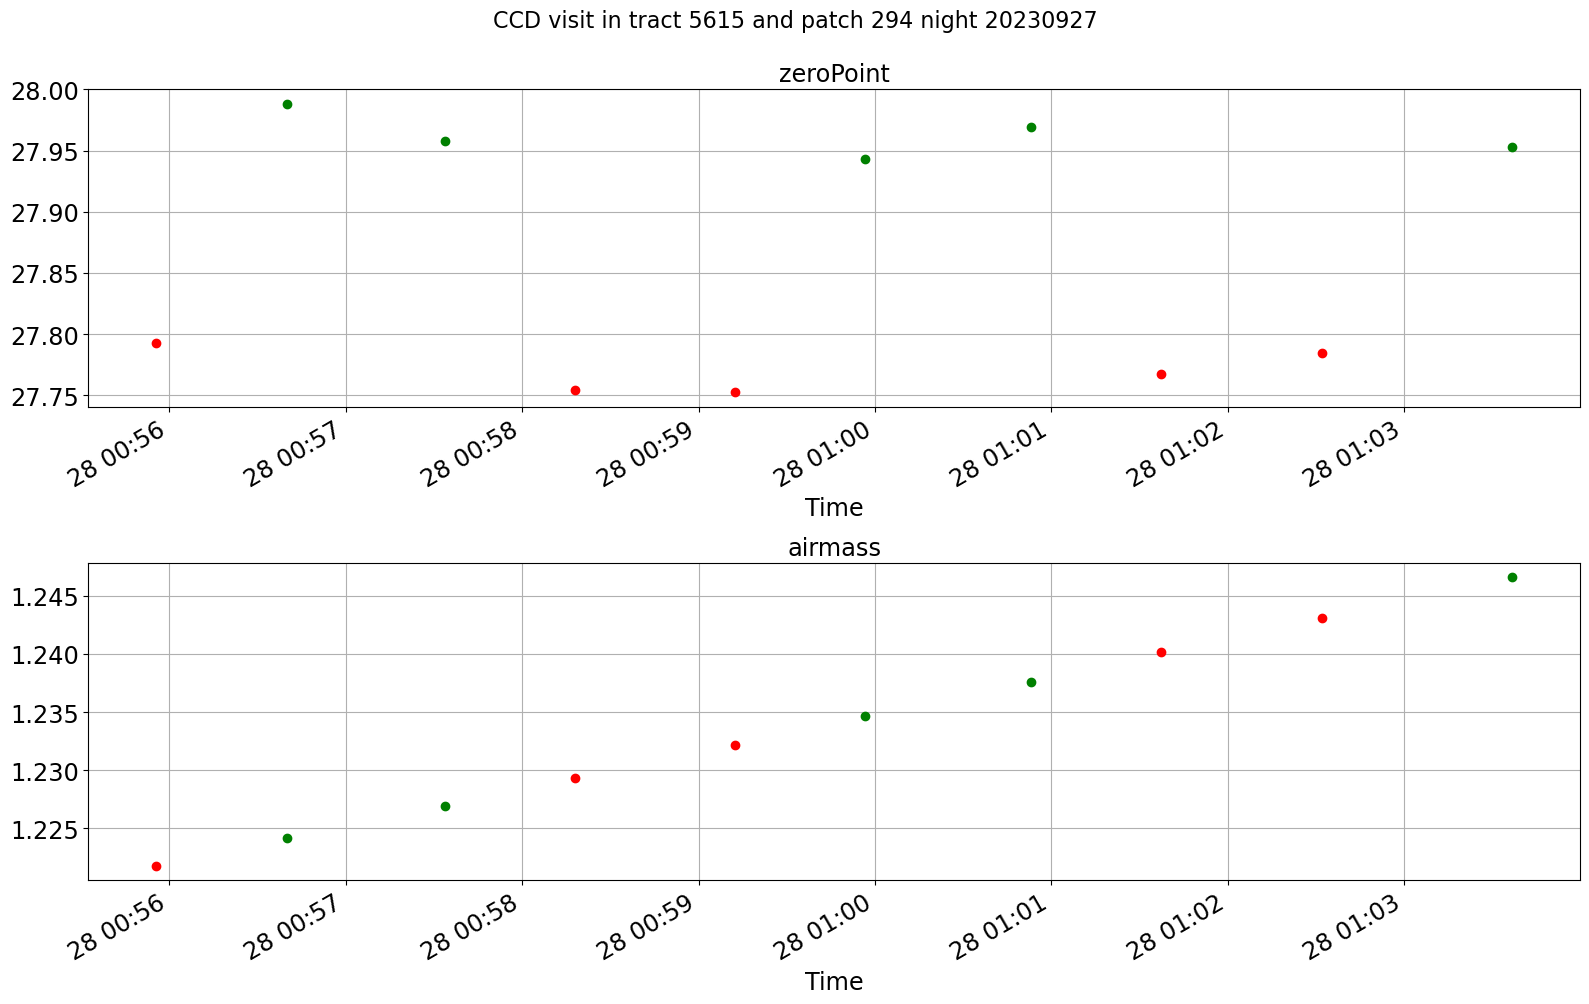

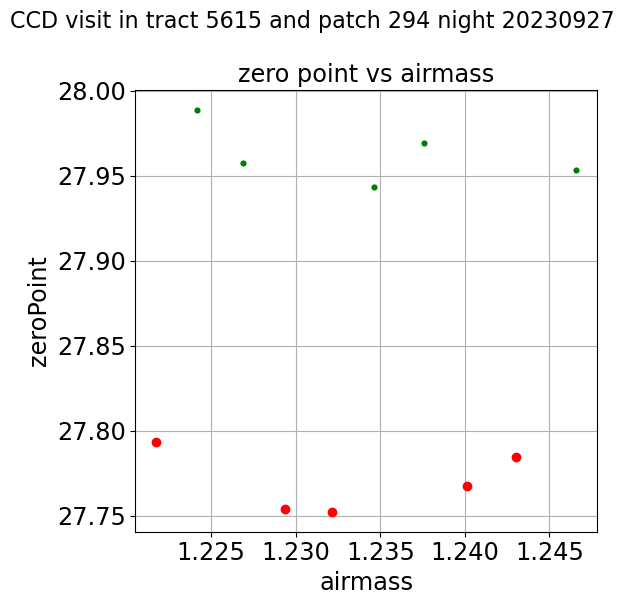

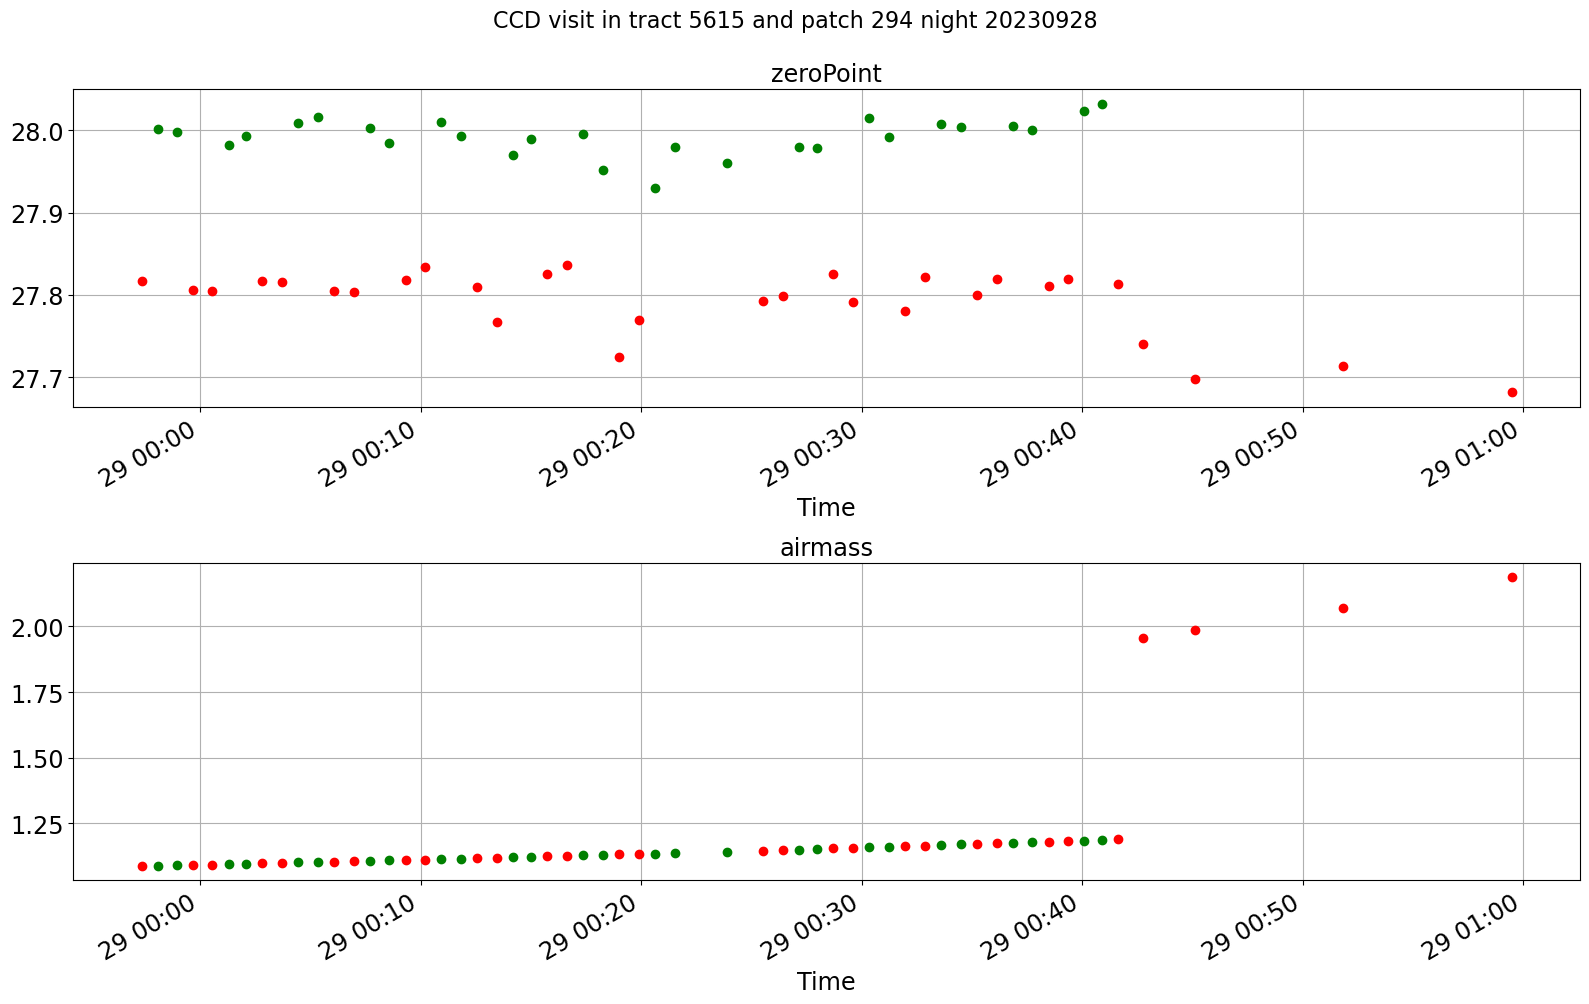

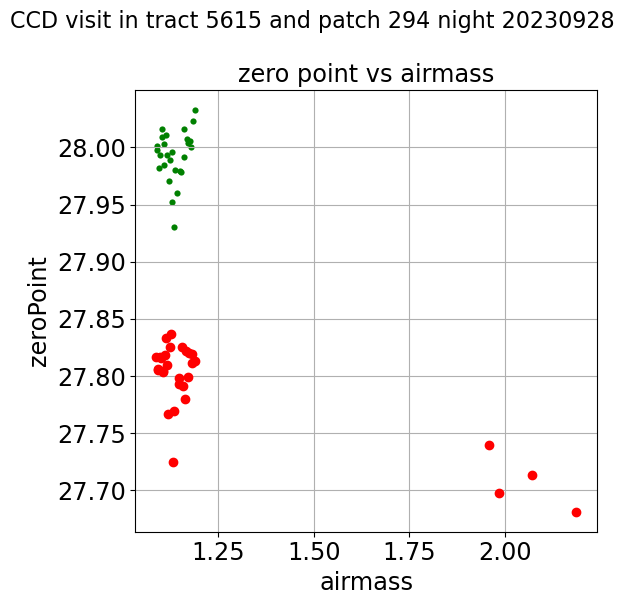

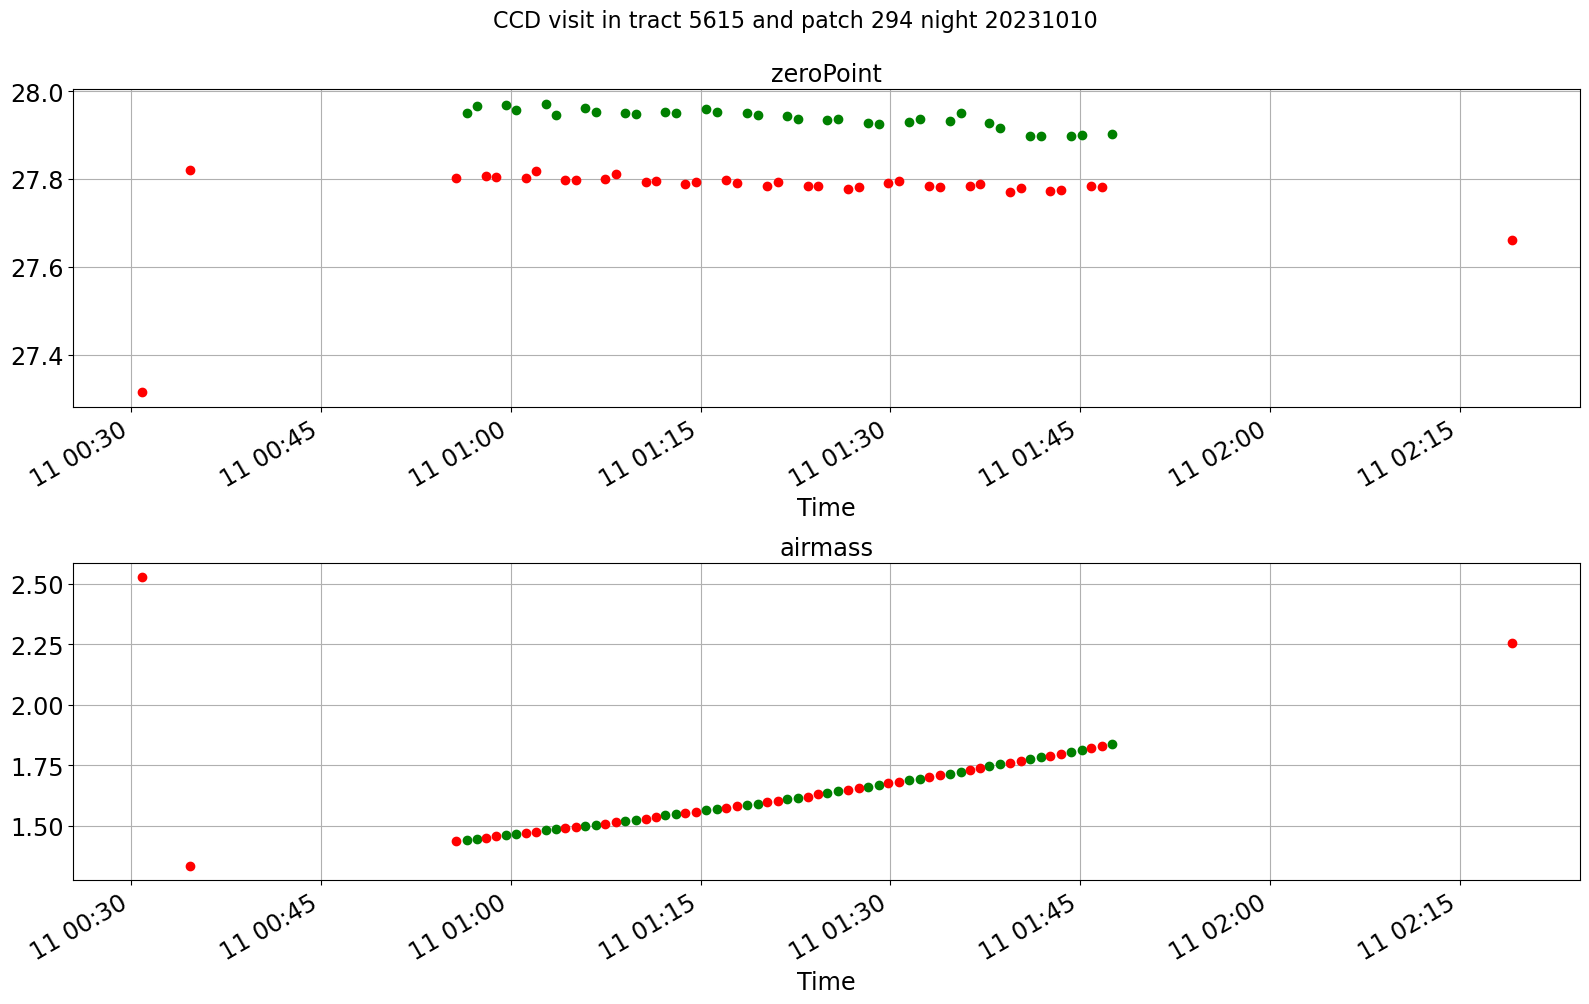

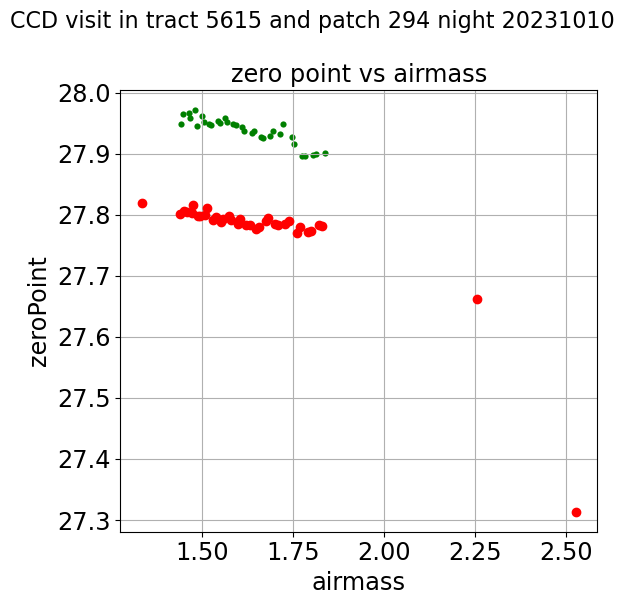

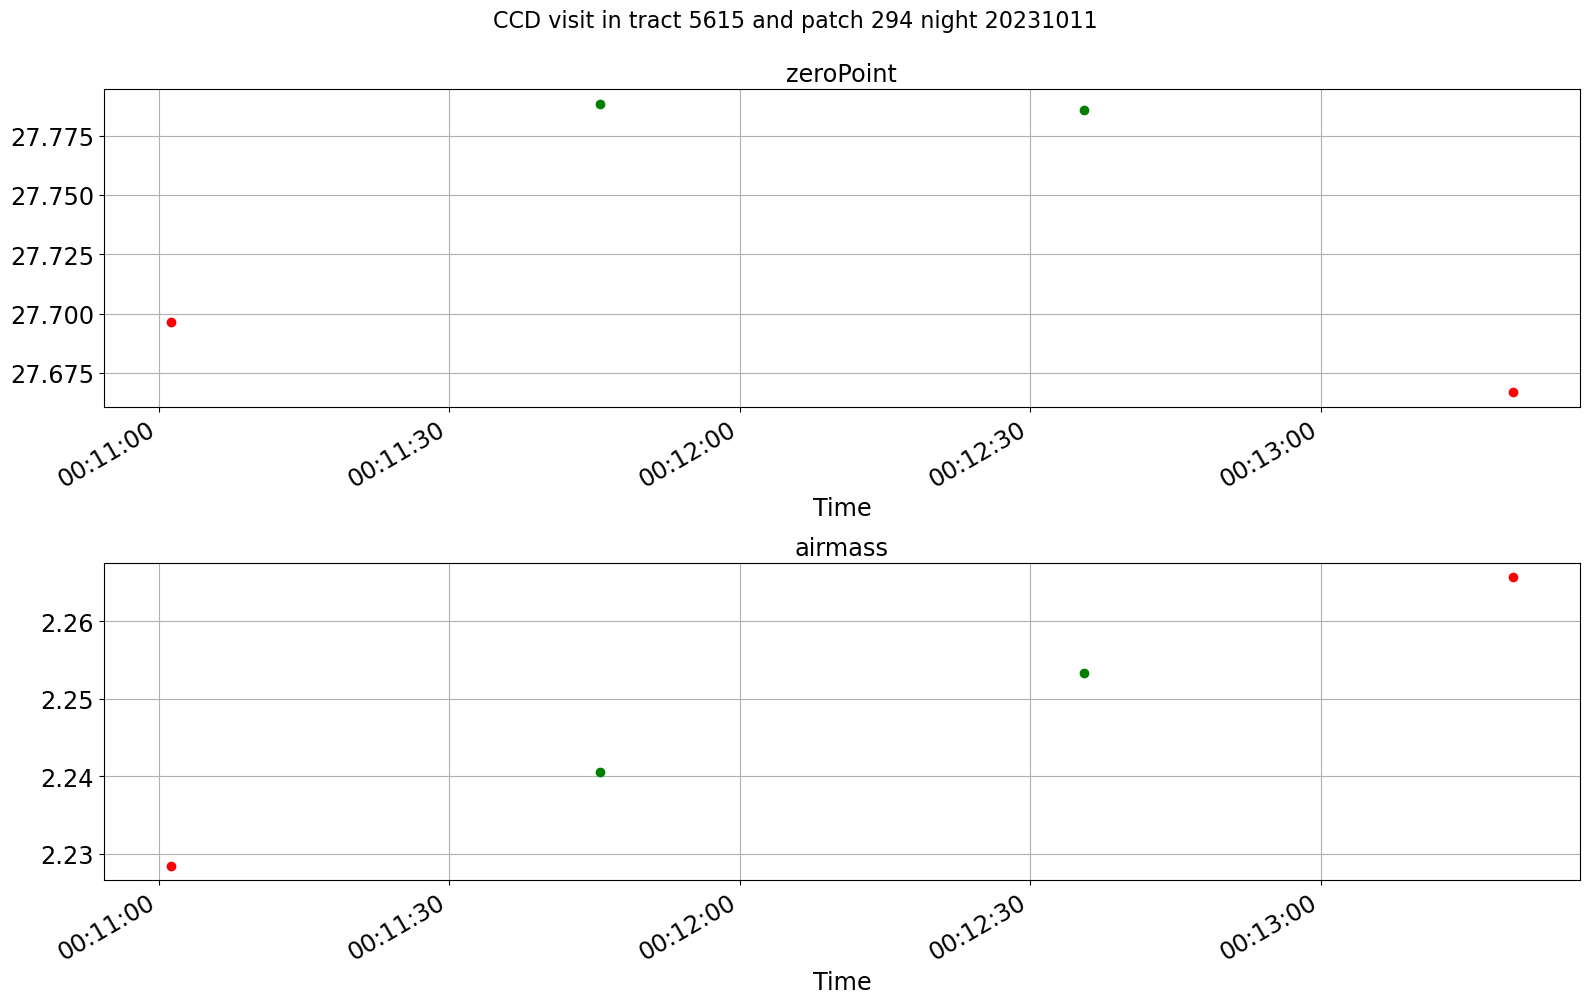

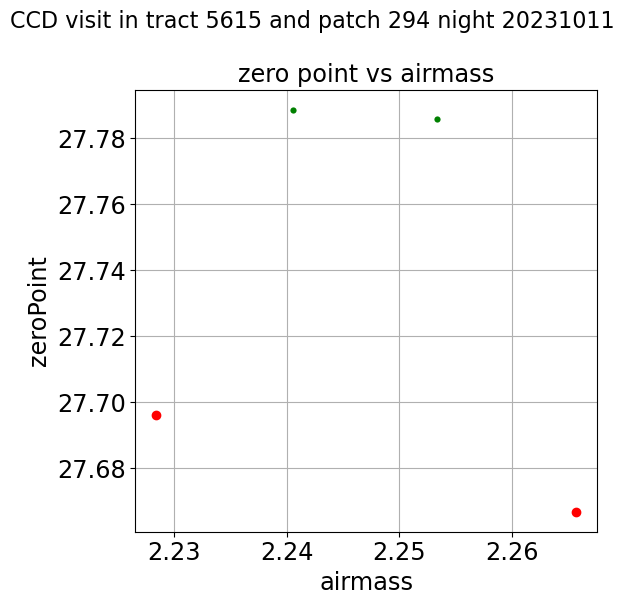

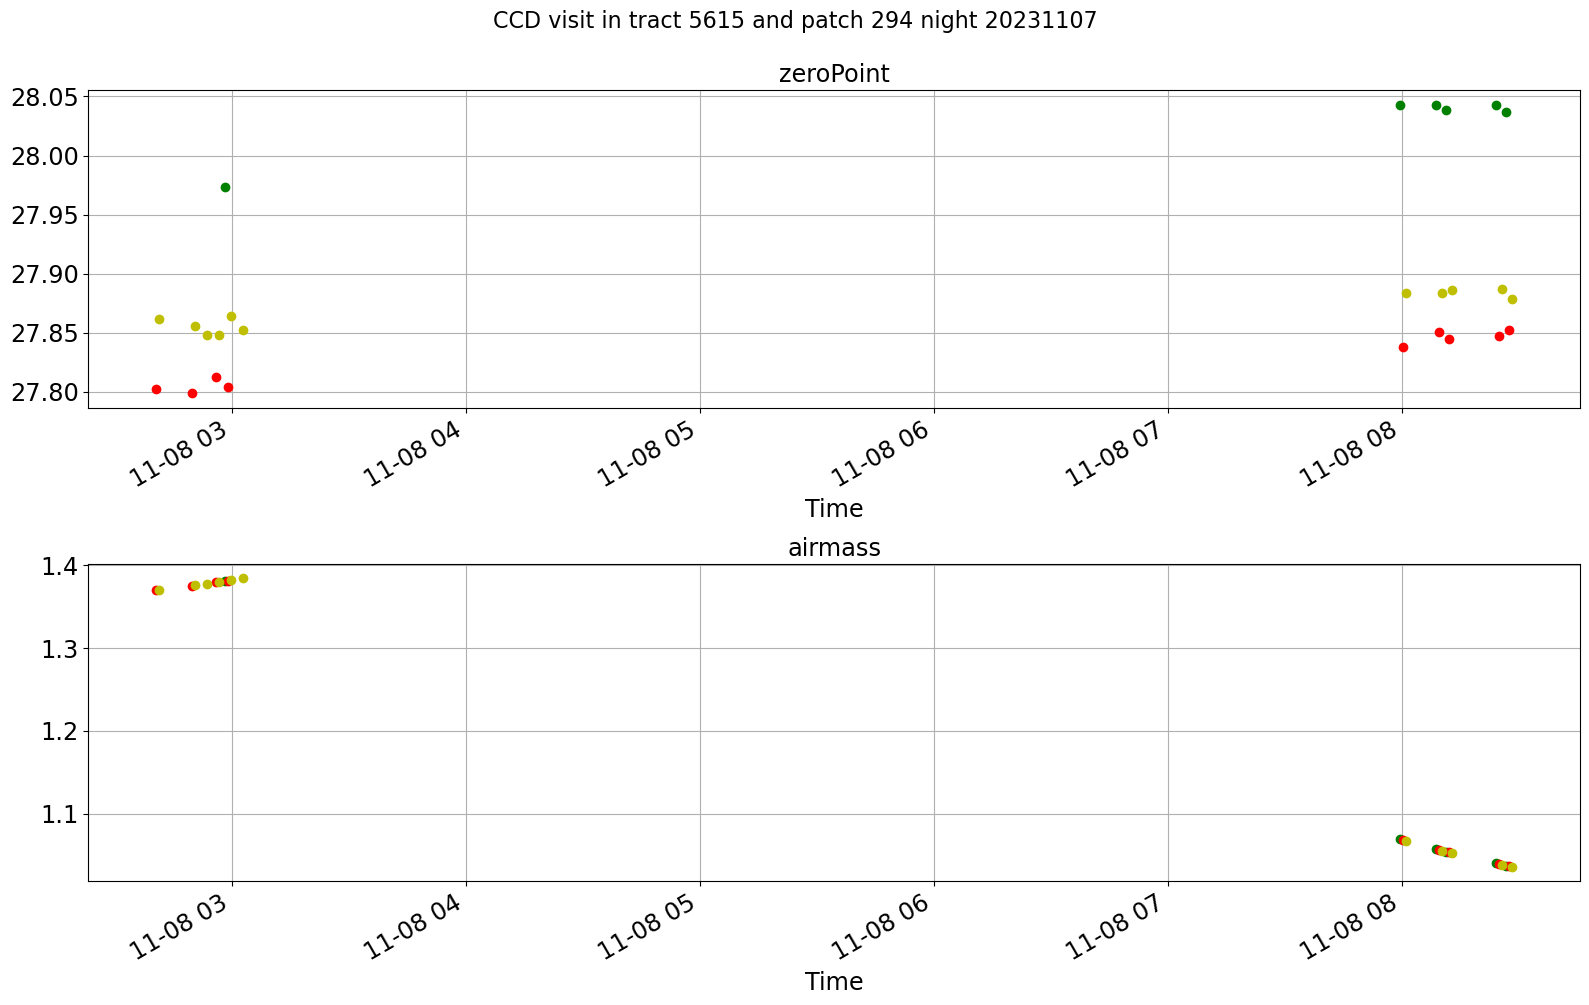

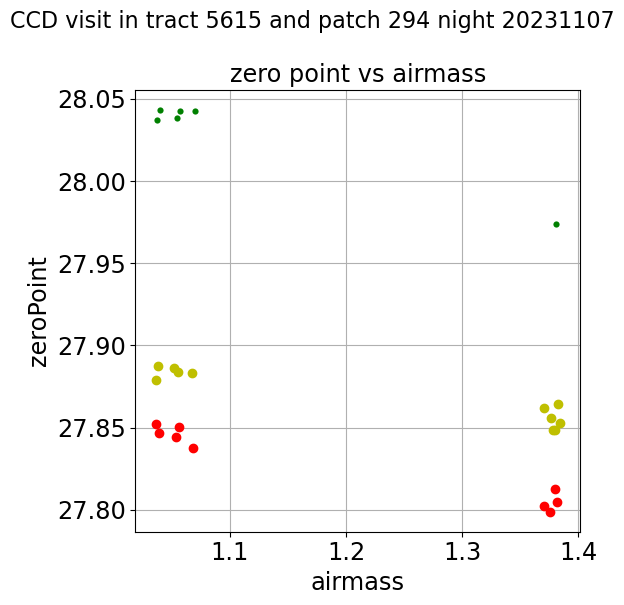

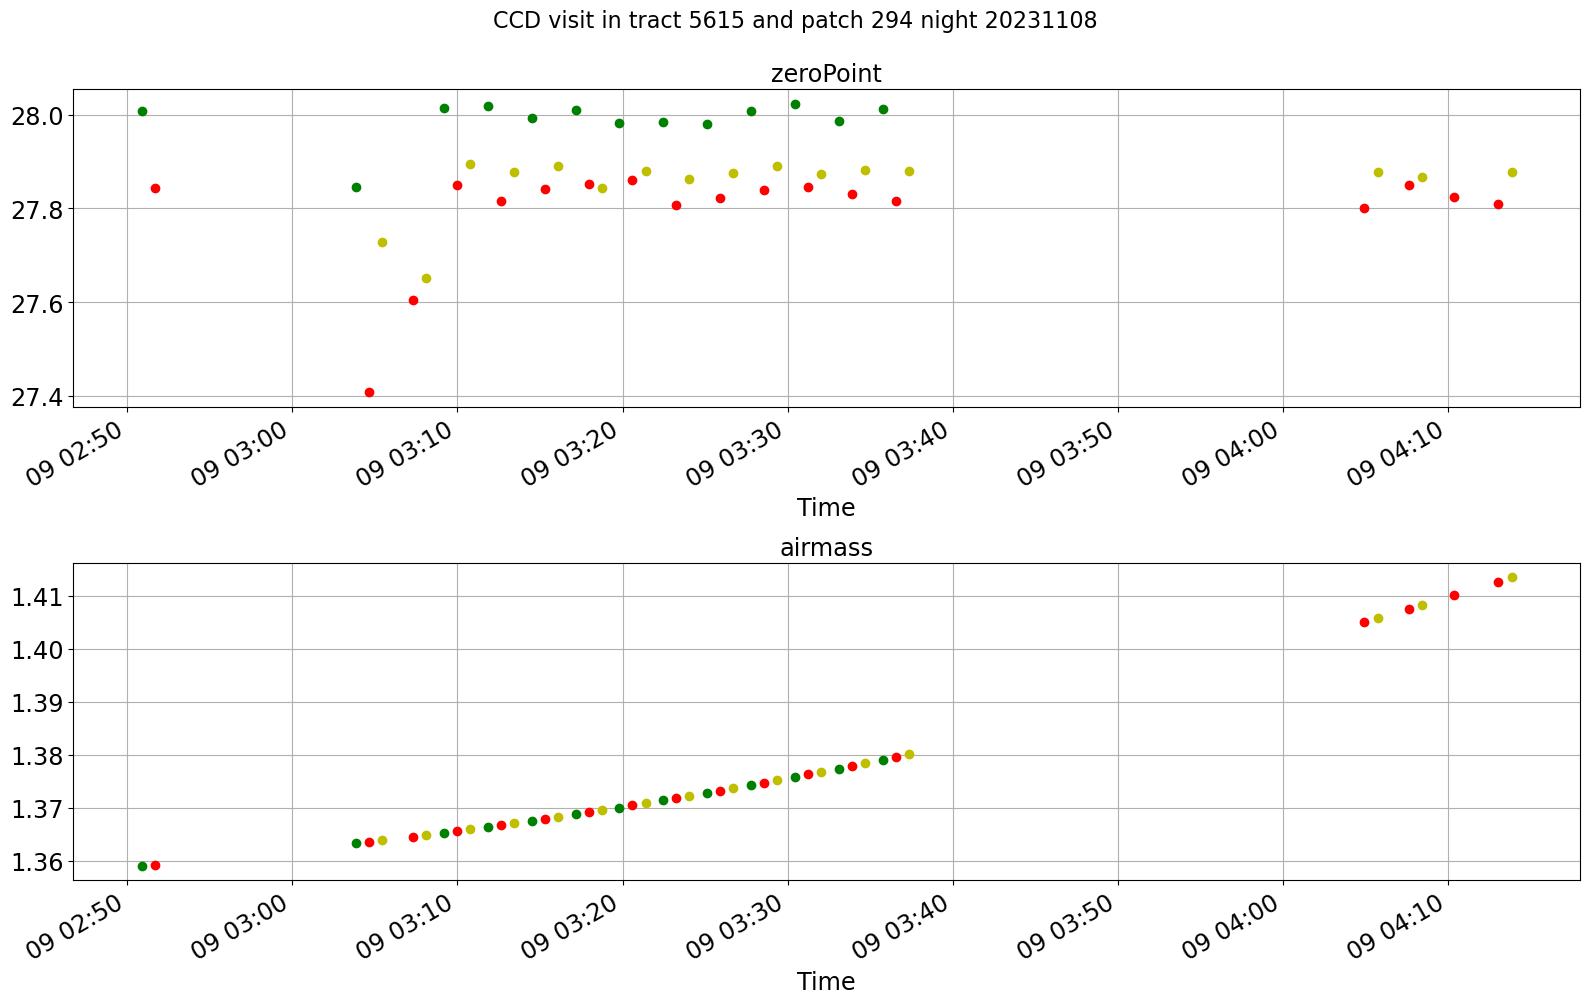

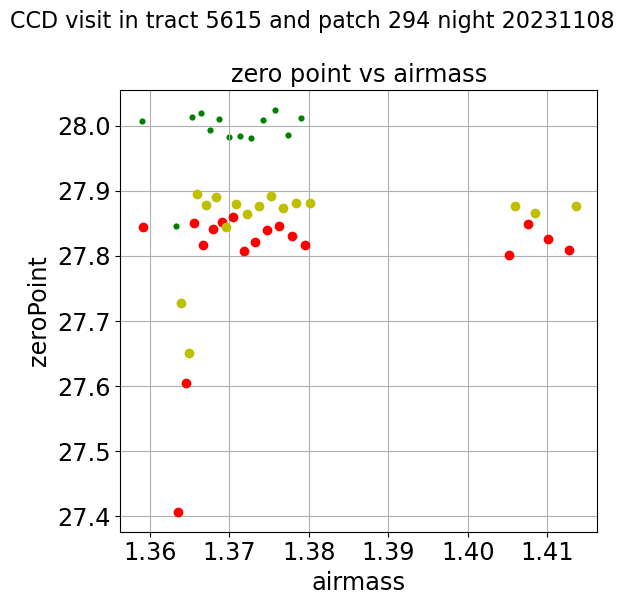

In [64]:
all_night_obs = ccd_visit_table['nightObs'].unique()
for nightObs_selected in all_night_obs:
    ccd_visit_table_nightsel = ccd_visit_table[ccd_visit_table.nightObs == nightObs_selected]
    ccd_visit_table_nightselcount_byband = ccd_visit_table_nightsel.groupby(['band']).count()["visitId"]
    ccd_visit_table_nightselcountsum = ccd_visit_table_nightselcount_byband.sum() 
    df = ccd_visit_table_nightsel

    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
    df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
    df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
    df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
    ax1.set_title("zeroPoint")

    df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
    df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
    df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
    ax2.set_title("airmass")
    plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(6,6))

    df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
    df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
    df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
    ax.set_title("zero point vs airmass")

    plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()

